### **Analyze all CV Results**

In [0]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import itertools
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import files #Google colab ONLY

In [2]:
## If export the output to Google Drive (colab ONLY) --> Optional
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
path = '/content/drive/My Drive/kdd2020_cv'
sys.path.append(path)

In [4]:
# data*x* "$path"/wwdata-0.2.3
!ls "$path"


data_0-12_2020-01-16.xlsx    data_200-50_2020-01-16.xlsx
data_0-22_2020-01-16.xlsx    data_200-75_2020-01-16.xlsx
data_0-25_2020-01-16.xlsx    data_200-78_2020-01-16.xlsx
data_0-45_2020-01-16.xlsx    data_300-20_2020-01-16.xlsx
data_0-50_2020-01-16.xlsx    data_300-25_2020-01-16.xlsx
data_0-7_2020-01-16.xlsx     data_400-16_2020-01-16.xlsx
data_100-19_2020-01-16.xlsx  data_400-25_2020-01-16.xlsx
data_100-25_2020-01-16.xlsx  data_400-50_2020-01-16.xlsx
data_100-44_2020-01-16.xlsx  data_400-73_2020-01-16.xlsx
data_100-48_2020-01-16.xlsx  data_400-75_2020-01-16.xlsx
data_100-50_2020-01-16.xlsx  data_400-83_2020-01-16.xlsx
data_100-75_2020-01-16.xlsx  df_fit.xlsx
data_200-25_2020-01-16.xlsx  wwdata-0.2.3


In [5]:
!pip install weightwatcher #install from source
#!pip install powerlaw #needed if install ww from local

In [6]:
import weightwatcher as ww

# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# crea
import logging
logger = logging.getLogger("imported_module")
logger.setLevel(logging.CRITICAL)

Using TensorFlow backend.


In [7]:
!pip install pytorchcv

In [8]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch

import pytorchcv
import pytorchcv.models.model_store

modelnames = pytorchcv.models.model_store._model_sha1.keys()
modelnames = list(modelnames)
print('{} models to examine'.format(len(modelnames)))

488 models to examine


### 1. Read in all pre-computed Data 

In [11]:
try:
    ## Load the model results data
    # df_all = pd.read_excel('/content/drive/My Drive/df_all.xlsx')\
    #       .rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
    df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
    df_all.head()

except:
    ## If the above cell runs different batches of the data
    ## Use this cell to concat the data together
    print('Concating files...')
    df_all = pd.DataFrame()
    for f in os.listdir(path):
        if f.startswith('data_'): #detect data
            tempp = pd.read_excel(path + '/' + f)\
                        .rename(columns = {'Unnamed: 0':'modelname'})
            df_all = pd.concat([df_all, tempp], axis = 0, sort = False)
            #print(f)
            #print(df_all.tail(1))

    del tempp

    df_all = df_all.drop_duplicates().reset_index(drop = True)

print(len(df_all))
#df_all.dropna(inplace=True)
#print(len(df_all))

Concating files...
311


In [0]:
#!ls "$path"/df_all.xlsx

In [13]:
df_all

,modelname,check,check_compound,checkTF,checkTF_compound,norm,norm_compound,lognorm,lognorm_compound,normX,normX_compound,lognormX,lognormX_compound,alpha,alpha_compound,alpha_weighted,alpha_weighted_compound,spectralnorm,spectralnorm_compound,logspectralnorm,logspectralnorm_compound,softrank,softrank_compound,softranklog,softranklog_compound,softranklogratio,softranklogratio_compound,sigma_mp,sigma_mp_compound,numofSpikes,numofSpikes_compound,ratio_numofSpikes,ratio_numofSpikes_compound,softrank_mp,softrank_mp_compound,logpnorm,logpnorm_compound
0,mobilenetv2_w3d4,0.408237,0.114709,0.066667,0.009009,8.938941,8.938941,0.892522,0.892522,8.628367,8.628367,0.809511,0.809511,4.624100,4.624100,1.144997,1.144997,2.452255,1.655736,0.240704,0.140576,40.372124,40.372124,1.529651,1.529651,-10.764965,-10.764965,0.692609,0.692609,9.800000,9.800000,0.078341,0.078341,0.603524,0.603524,1.681911,1.681911
1,mobilenetv2_w1,0.389093,0.102414,0.111111,0.015015,7.888319,7.888319,0.839303,0.839303,7.027844,7.027844,0.728370,0.728370,4.716352,4.716352,0.907540,0.907540,2.642529,1.779791,0.256707,0.167164,35.412312,35.412312,1.470379,1.470379,23.656982,23.656982,0.627113,0.627113,10.434783,10.434783,0.092442,0.092442,0.541662,0.541662,1.413796,1.413796
2,mobilenetv3_large_w1,0.471997,0.140806,0.052632,0.006803,13.214663,13.214663,1.064789,1.064789,19.711300,19.711300,1.182721,1.182721,4.203620,4.203620,3.001442,3.001442,9.961053,6.159210,0.737898,0.617192,31.398933,31.398933,1.409887,1.409887,3.445639,3.445639,0.802449,0.802449,34.000000,34.000000,0.192538,0.192538,0.314067,0.314067,3.479227,3.479227
3,igcv3_wd4,0.272994,0.162060,0.106667,0.026534,18.332186,18.332186,1.150082,1.150082,34.816528,34.816528,1.294861,1.294861,3.839036,3.839036,2.425316,2.425316,1.552103,1.476130,0.081193,0.061311,56.928752,56.928752,1.716897,1.716897,5.624685,5.624685,0.880873,0.880873,67.333333,67.333333,0.160659,0.160659,0.718617,0.718617,3.511312,3.511312
4,igcv3_wd2,0.253947,0.109901,0.066667,0.008292,10.135278,10.135278,0.895790,0.895790,12.739136,12.739136,0.848466,0.848466,5.963145,5.963145,1.847061,1.847061,1.595783,1.382037,-inf,-inf,38.317941,38.317941,1.493196,1.493196,16.597782,16.597782,0.708497,0.708497,20.777778,20.777778,0.061621,0.061621,0.708041,0.708041,2.250735,2.250735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,preresnet26,1.417044,0.871028,0.799257,0.820627,8.698458,8.658644,0.905574,0.890431,10.422018,10.043399,0.954902,0.909896,3.353660,3.494593,2.110335,1.945414,12.292718,6.179618,0.748720,0.565530,19.398412,23.454458,1.205844,1.244857,3.228196,0.243278,0.921806,0.873345,2.231818,2.615079,0.016345,0.018776,0.968605,0.926630,2.539925,2.385639
307,preresnetbc26b,1.923161,0.399779,0.514085,0.267347,8.801484,8.730163,0.910042,0.890402,9.946896,8.447763,0.942897,0.828137,3.549477,4.496689,1.916695,1.631391,18.757603,5.167788,0.848985,0.423972,23.359376,31.548391,1.255375,1.390067,6.032981,12.460883,0.863415,0.646415,5.827957,16.544061,0.029034,0.073706,0.840359,0.610259,2.376383,2.055879
308,preresnet34,1.210359,0.788568,0.847507,0.860514,7.866827,7.894940,0.867597,0.860032,8.356062,8.201743,0.862378,0.837080,3.420574,3.467145,1.720756,1.619923,9.394811,4.812236,0.613857,0.471159,21.114409,23.960355,1.245828,1.273436,4.712324,2.950923,0.922045,0.883865,1.500000,1.870370,0.011611,0.014262,1.261983,1.201694,2.184712,2.098635
309,preresnetbc38b,1.636872,0.357473,0.591398,0.286686,8.039993,7.766750,0.872862,0.848162,8.285189,6.877547,0.866346,0.752892,3.620167,4.484285,1.552138,1.132628,16.703903,4.274858,0.730644,0.352531,22.813636,27.967666,1.264846,1.369963,3.759107,3.600825,0.856890,0.623130,4.978102,15.246612,0.023465,0.067470,1.020744,0.661828,2.001607,1.550771


# Remove Outliers

- EfficientNet b0 and b1
- ResNext CIFAR00 all models



In [19]:
print("before removing outliers, we have {}".format(len(df_all)) )
bad_models = ['efficientnet_b0', 'efficientnet_b1']
bad_models.extend(['resnext272_2x32d_cifar100', 'resnext29_16x64d_cifar100','resnext29_32x4d_cifar100','resnext272_1x64d_cifar100'])
for mname in bad_models:
  df_all = df_all[df_all.modelname!=mname]
print("after removing outliers, we have {}".format(len(df_all)) )


before removing outliers, we have 311
after removing outliers, we have 305


In [0]:
## Get the modelname of outliers
# temp = df_all.copy()
# temp = temp.sort_values(['softrank'], ascending = False)
# outliers_sr = temp['modelname'].tolist()[:10]

# temp = temp.sort_values(['spectralnorm'], ascending = False)
# outliers_sp = temp['modelname'].tolist()[:10]

# [s for s in outliers_sp if s not in outliers_sr]

In [0]:
## Get the details of outliers
# writer = pd.ExcelWriter('/content/drive/My Drive/sp_outliers.xlsx')
# for s in [s for s in outliers_sp if s not in outliers_sr]:#outliers:
#     model = ptcv_get_model(s, pretrained=True) #'resnet542bn_svhn'
#     watcher = ww.WeightWatcher(model=model, logger=logger)
#     results = watcher.analyze(compute_alphas = False, compute_spectralnorms=True, compute_softranks=True)
    
#     temp1 = watcher.get_details()
#     temp1.to_excel(writer, s)
    
# writer.save()

### **2. Plots with Test Accuracies**

In [0]:
from bs4 import BeautifulSoup
import requests
import re

In [0]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [0]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [0]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))


In [0]:
'''Match the model name using matchtable'''
# df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
df_all['spectralnormlog'] = np.log(df_all['spectralnorm'])

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))


In [27]:
df_full['imagenet-1k']

,Model,Top1,Top5,Params,FLOPs/2,modelname,group,check,check_compound,checkTF,checkTF_compound,norm,norm_compound,lognorm,lognorm_compound,normX,normX_compound,lognormX,lognormX_compound,alpha,alpha_compound,alpha_weighted,alpha_weighted_compound,spectralnorm,spectralnorm_compound,logspectralnorm,logspectralnorm_compound,softrank,softrank_compound,softranklog,softranklog_compound,softranklogratio,softranklogratio_compound,sigma_mp,sigma_mp_compound,numofSpikes,numofSpikes_compound,ratio_numofSpikes,ratio_numofSpikes_compound,softrank_mp,softrank_mp_compound,logpnorm,logpnorm_compound,spectralnormlog
0,AlexNet,40.96,18.24,62378344,"1,132.33M",alexnet,AlexNet,6.312063,1.803071,0.193182,0.383333,17.027948,19.122663,1.213128,1.270097,50.047062,37.898106,1.587062,1.522654,2.653116,2.629965,3.361279,3.131412,110.108810,34.962147,1.812696,1.299864,15.736961,26.715962,1.145412,1.348129,1.961531,2.196280,0.796720,0.724677,39.181818,93.934603,0.221105,0.142307,0.123766,0.121950,3.811582,3.626827,4.701469
1,AlexNet-b,41.58,19.00,61100840,714.83M,alexnetb,AlexNet,5.415376,1.641999,0.204545,0.393333,15.142357,18.014004,1.158144,1.238356,42.394821,33.721260,1.507646,1.472359,2.591940,2.611971,3.114341,3.013202,80.635475,28.471046,1.663680,1.251299,14.278321,24.886991,1.100462,1.313405,1.977554,2.185516,0.862794,0.743370,32.581818,96.579048,0.224065,0.145615,0.151018,0.130632,3.551809,3.467992,4.389939
2,ZFNet,39.79,17.27,62357608,"1,170.33M",zfnet,ZFNet,4.725841,1.786327,0.211538,0.305556,17.195885,19.206074,1.228810,1.275319,47.623081,37.862602,1.632585,1.541956,2.756450,2.674295,3.673229,3.257409,77.114090,33.421925,1.672296,1.318818,14.951624,26.439746,1.118418,1.335730,1.885556,2.168971,0.790251,0.719677,40.036364,92.902857,0.225115,0.144605,0.108592,0.113837,4.081376,3.739922,4.345286
3,ZFNet-b,36.37,14.90,107627624,"2,479.13M",zfnetb,ZFNet,5.037417,1.844308,0.221154,0.319444,19.061750,21.009226,1.272548,1.315737,53.744839,41.878025,1.687328,1.585046,2.655884,2.636655,3.646447,3.286362,91.156982,38.146049,1.732795,1.354696,17.095301,29.968735,1.162326,1.386917,1.894057,2.190090,0.706738,0.650784,63.672727,132.488889,0.265277,0.182669,0.063393,0.074588,4.095295,3.805100,4.512583
4,VGG-11,29.90,10.36,132863336,"7,615.87M",vgg11,VGG/BN-VGG,1.943881,1.474718,0.653333,0.494949,16.136616,18.019598,1.199311,1.242720,33.025490,32.176971,1.497726,1.491117,2.718865,2.633820,3.173529,3.013562,25.952868,22.639509,1.267745,1.222273,19.147906,26.872274,1.226026,1.337490,2.089823,2.210968,0.826833,0.757683,31.818182,87.777778,0.132913,0.131504,0.196762,0.169916,3.634474,3.530661,3.256282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,ResNet(A)-101b,19.78,5.03,44568392,"8,072.93M",resneta101b,ResNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,ResNet(A)-152b,19.62,4.82,60212040,"11,796.83M",resneta152b,ResNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,ResNet(D)-50b,21.04,5.65,25680808,"20,497.60M",resnetd50b,ResNet,0.734454,0.317371,0.774038,0.319444,7.282118,7.152150,0.831089,0.808461,7.626557,6.354174,0.814939,0.686675,3.592766,3.997007,1.295728,0.880893,4.261870,2.885237,0.454681,0.253305,23.443366,29.784345,1.247373,1.383282,-1.276206,-20.486450,0.840987,0.583746,7.703518,24.818182,0.037639,0.093492,1.185150,0.684582,1.803401,1.385736,1.449708
257,ResNet(D)-101b,19.59,4.73,44672936,"35,392.65M",resnetd101b,ResNet,0.518111,0.222608,0.402532,0.165109,5.613925,5.438715,0.731803,0.707978,4.486915,3.689903,0.584489,0.467647,3.510758,4.042399,0.377081,-0.112405,2.396660,1.614072,0.201927,0.020544,23.389737,29.458223,1.287238,1.407417,2.846553,0.304874,0.821494,0.540957,4.624352,15.430818,0.022697,0.061941,1.

In [0]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank', 'norm', 'norm_compound' ] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog',  'softranklog',  'lognorm' ,'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

num_rows = 2
num_cols = 3

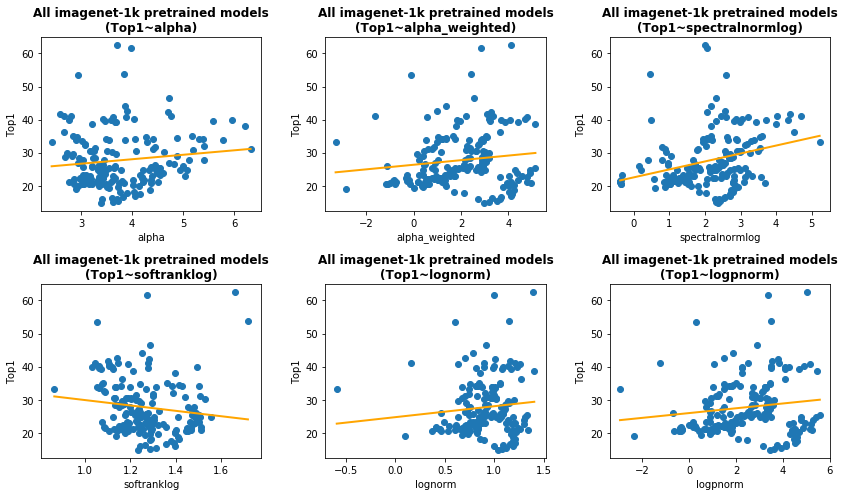

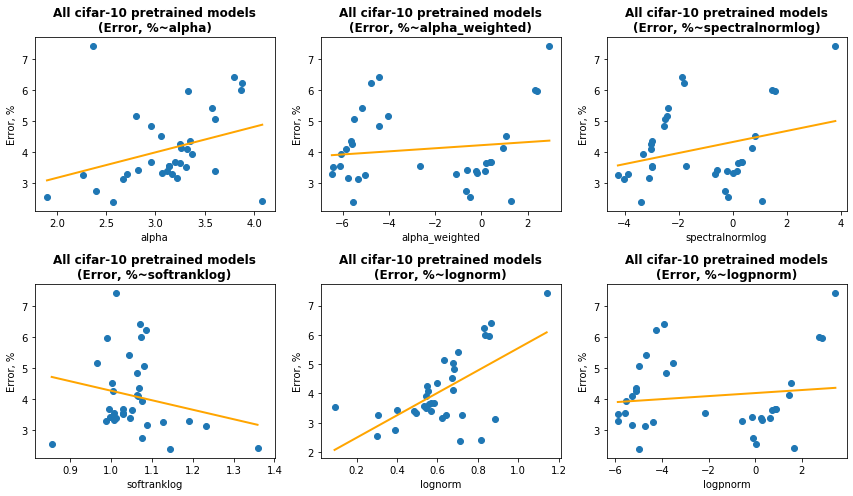

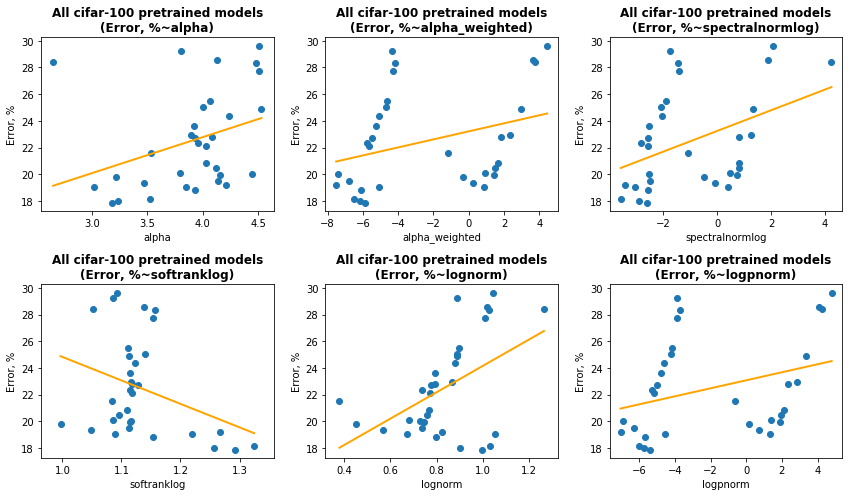

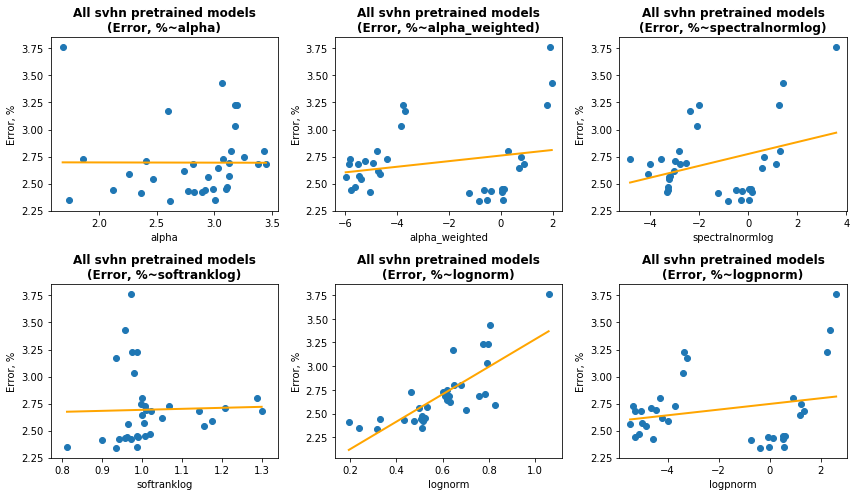

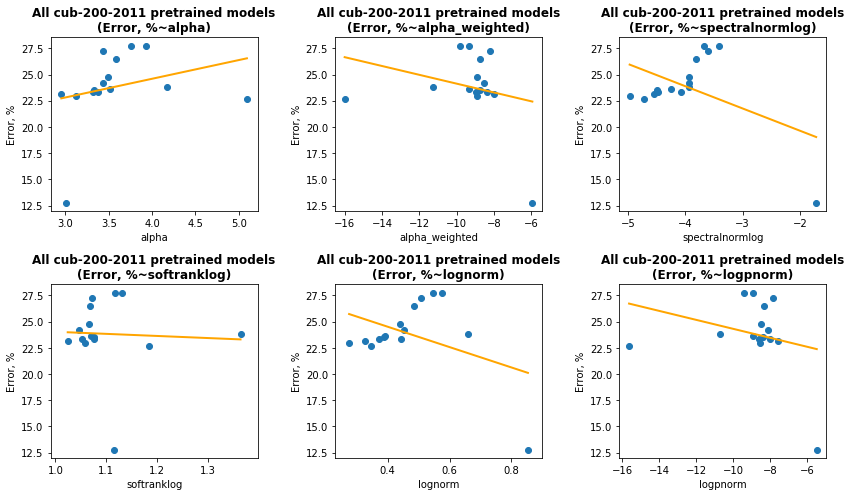

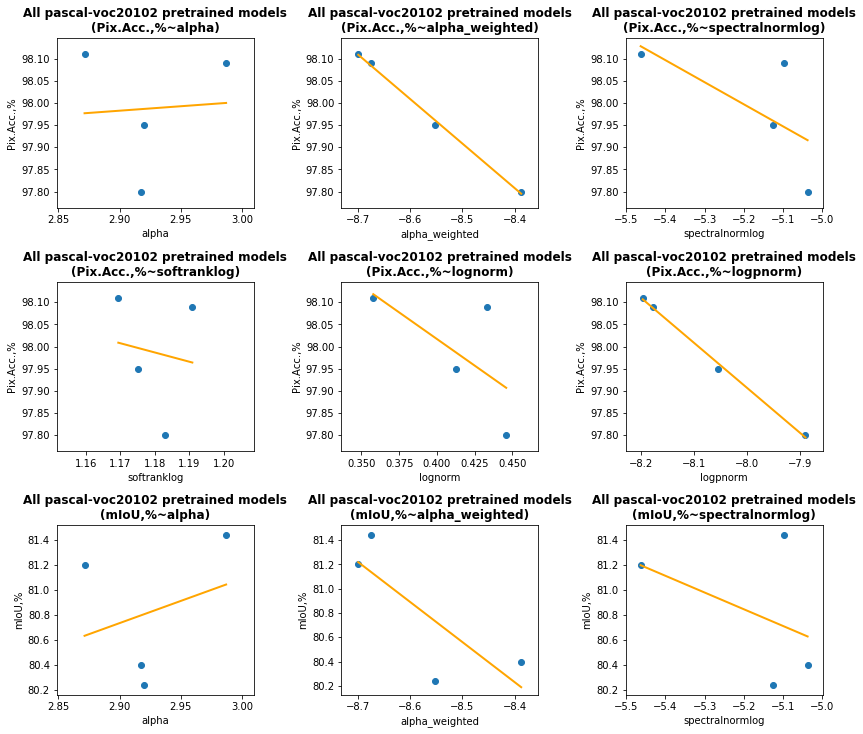

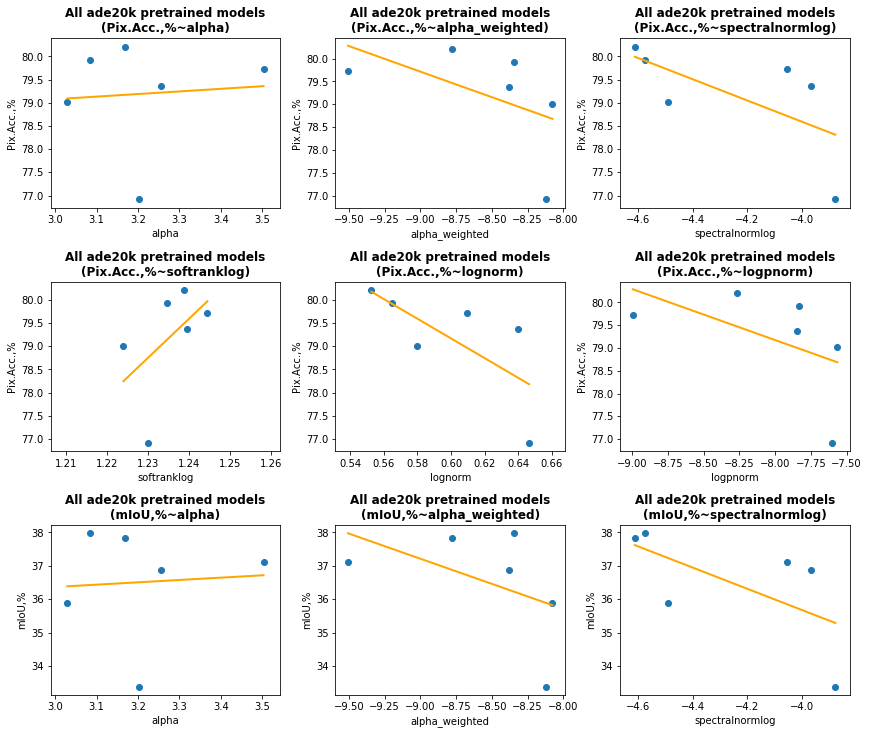

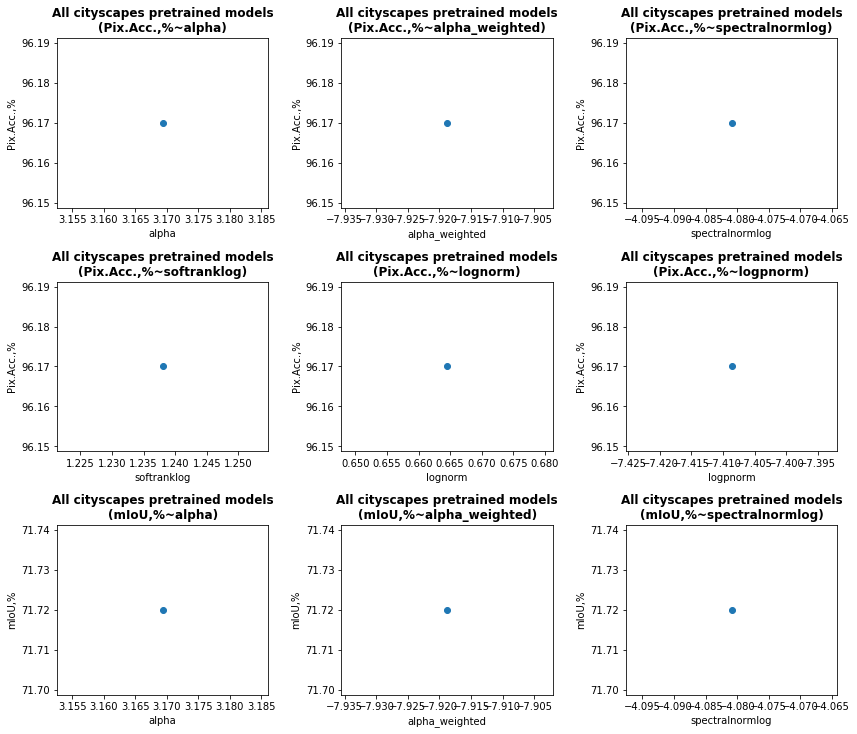

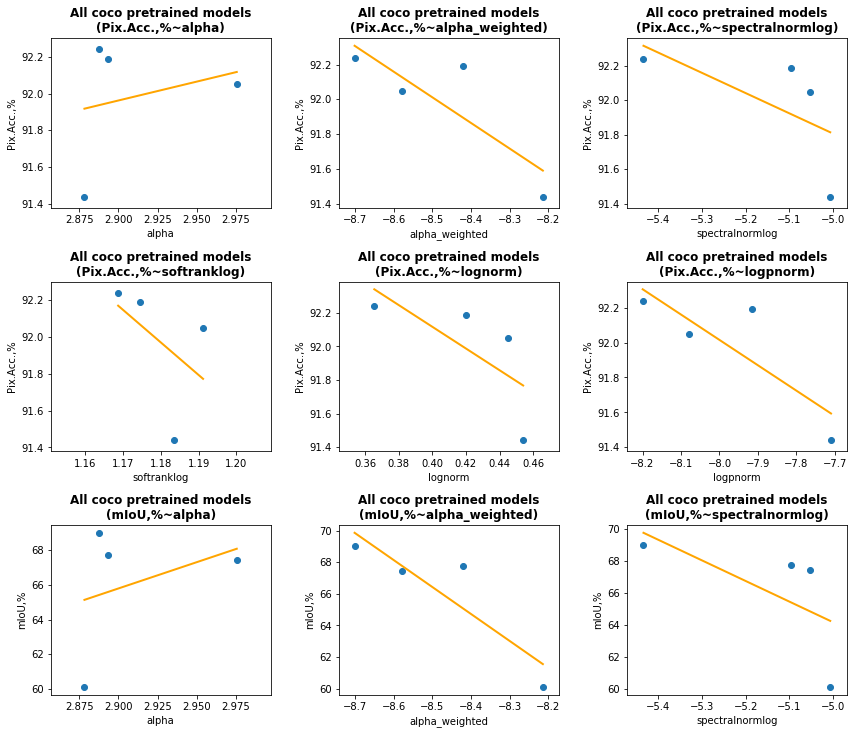

In [29]:
%matplotlib inline
plot_fit = True

'''Plotting by datasets'''
df_fit0 = []

for d in datasets:
    temp = df_full[d].copy()

    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]
    plotloc = int(len(tacc)*len(metrics)/num_rows*100 + 10*num_cols + 1)

    if len(tacc) > 1:
        plt.figure(figsize = (12,20))
    else:
        plt.figure(figsize = (12,10))

    try:
      for ac in tacc:#metrics_acc:
          for x in metrics:
              plt.subplot(plotloc)
              plt.scatter(temp[x], temp[ac])
              plt.xlabel(x)
              plt.ylabel(ac)
              plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                        fontweight = 'bold')

              if plot_fit == True:
                  temp = temp.dropna().reset_index(drop = True)
                  this_fit = sm.OLS(temp[ac], sm.add_constant(temp[x].to_numpy())).fit()
                  this_x = np.linspace(min(temp[x]), max(temp[x]), 1000)
                  plt.plot(this_x, this_fit.predict(sm.add_constant(this_x)), linewidth = 2, color = 'orange')
                  df_fit0.append([d, ac, x, this_fit.ssr/len(temp), this_fit.rsquared])
              plotloc += 1
    except:
      pass

    plt.tight_layout()

del temp
del tacc

if df_fit0 != []:
    df_fit0 = pd.DataFrame(df_fit0, columns = ['dataset', 'test accuracy', 'x variable', 'MSE', 'r^2'])

In [30]:
if type(df_fit0) != list:
    print(df_fit0.head(20))

        dataset test accuracy       x variable        MSE       r^2
0   imagenet-1k          Top1            alpha  69.824433  0.015165
1   imagenet-1k          Top1   alpha_weighted  69.593299  0.018425
2   imagenet-1k          Top1  spectralnormlog  64.606483  0.088761
3   imagenet-1k          Top1      softranklog  69.611485  0.018168
4   imagenet-1k          Top1          lognorm  70.159405  0.010440
5   imagenet-1k          Top1         logpnorm  69.521084  0.019443
6      cifar-10      Error, %            alpha   1.323065  0.104548
7      cifar-10      Error, %   alpha_weighted   1.453696  0.016137
8      cifar-10      Error, %  spectralnormlog   1.358424  0.080617
9      cifar-10      Error, %      softranklog   1.411063  0.044990
10     cifar-10      Error, %          lognorm   0.927769  0.372084
11     cifar-10      Error, %         logpnorm   1.454990  0.015260
12    cifar-100      Error, %            alpha  11.528381  0.114626
13    cifar-100      Error, %   alpha_weighted  

# Fit a linear regression for each Architecture Series , Dataset




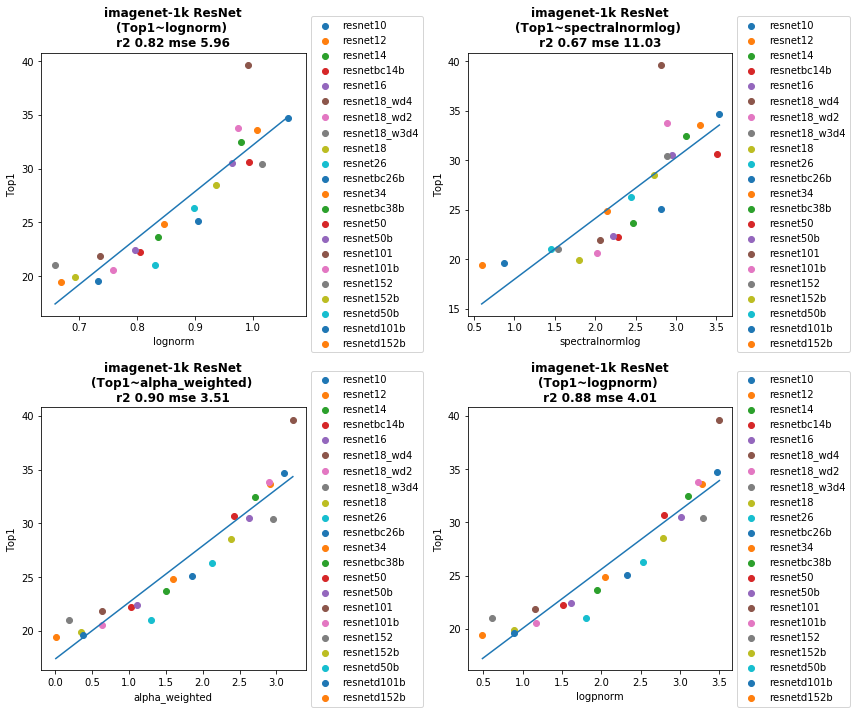

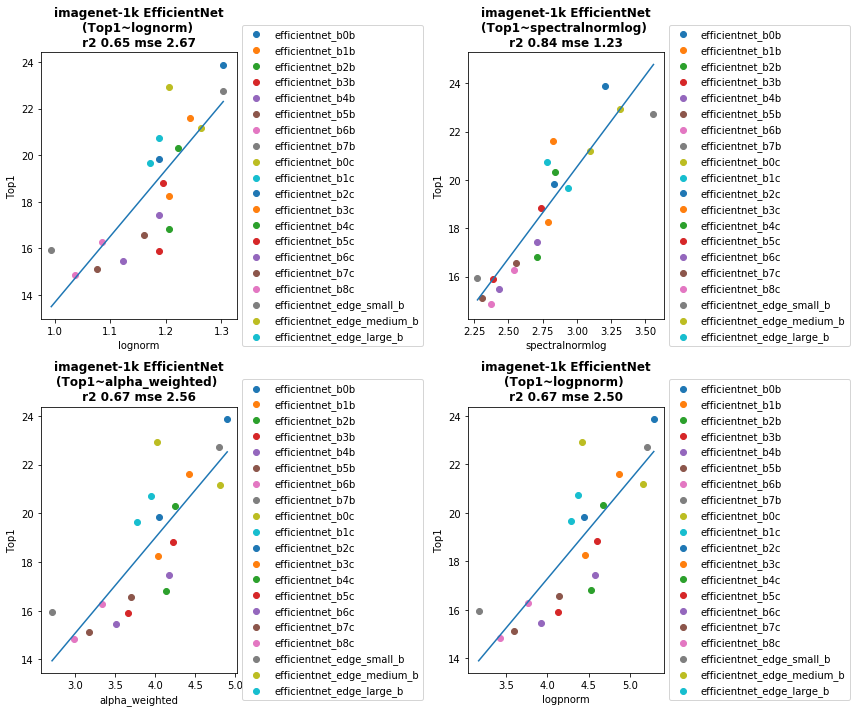

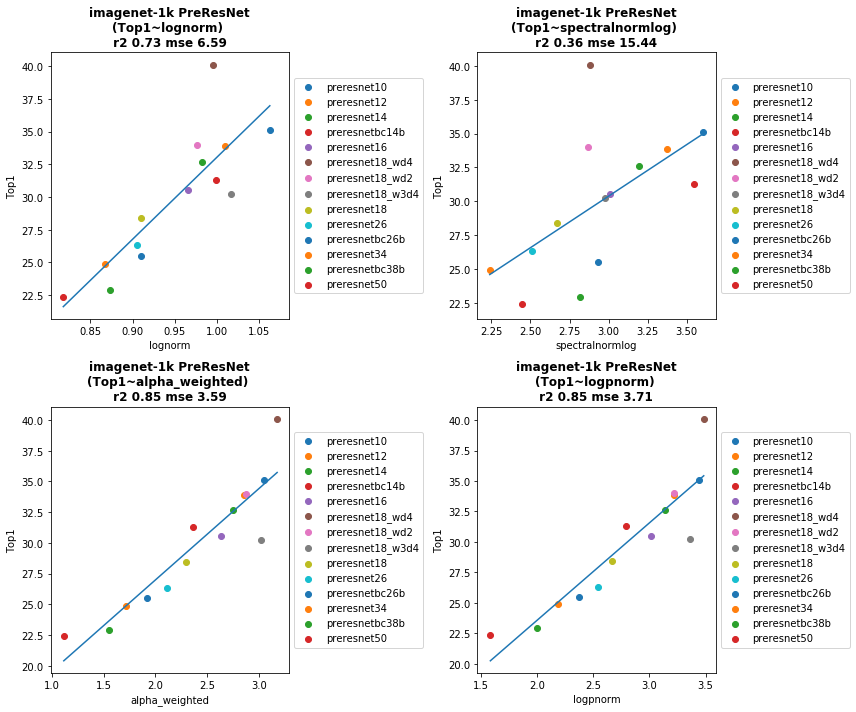

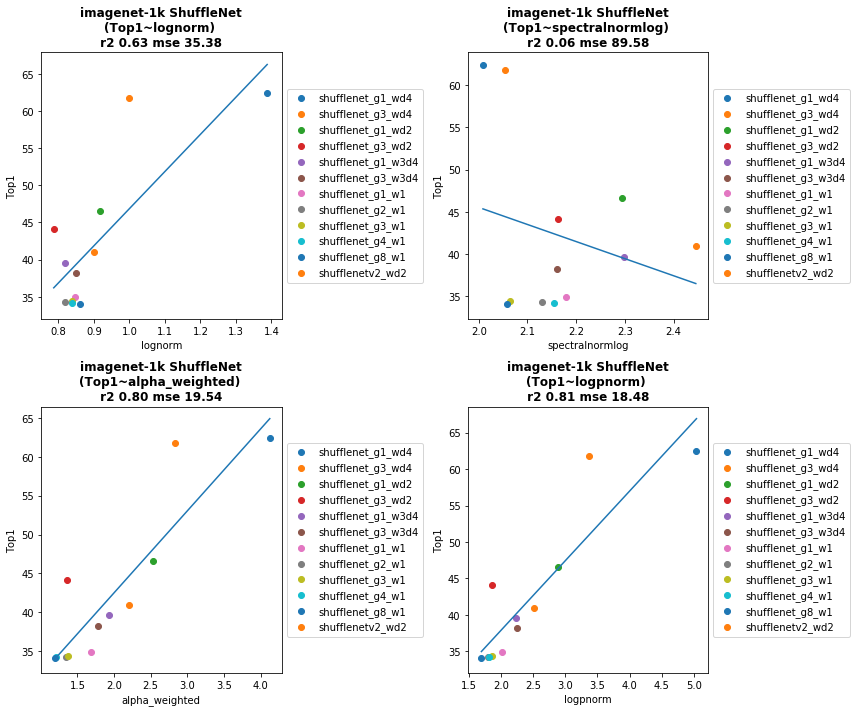

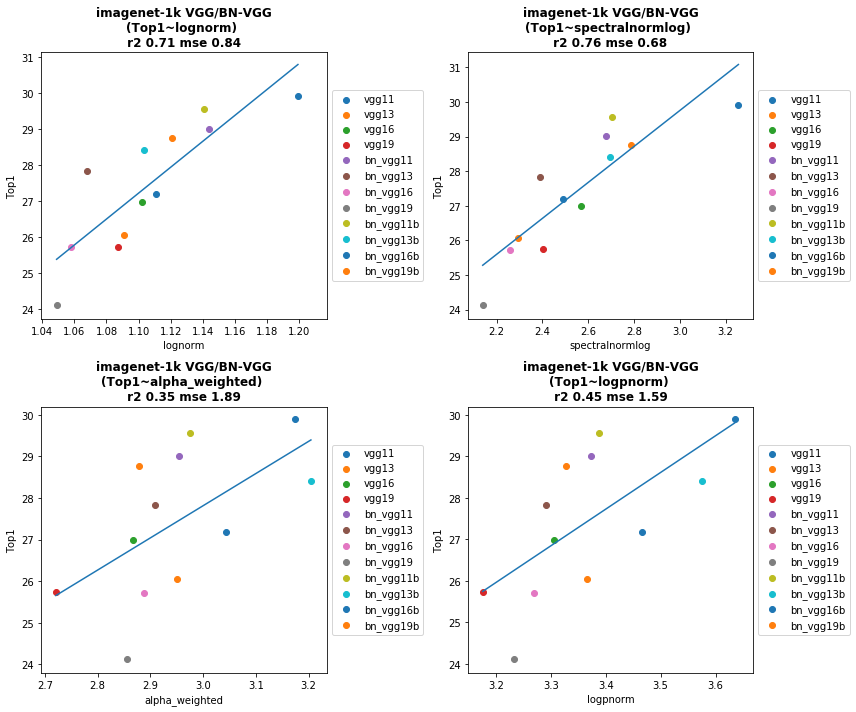

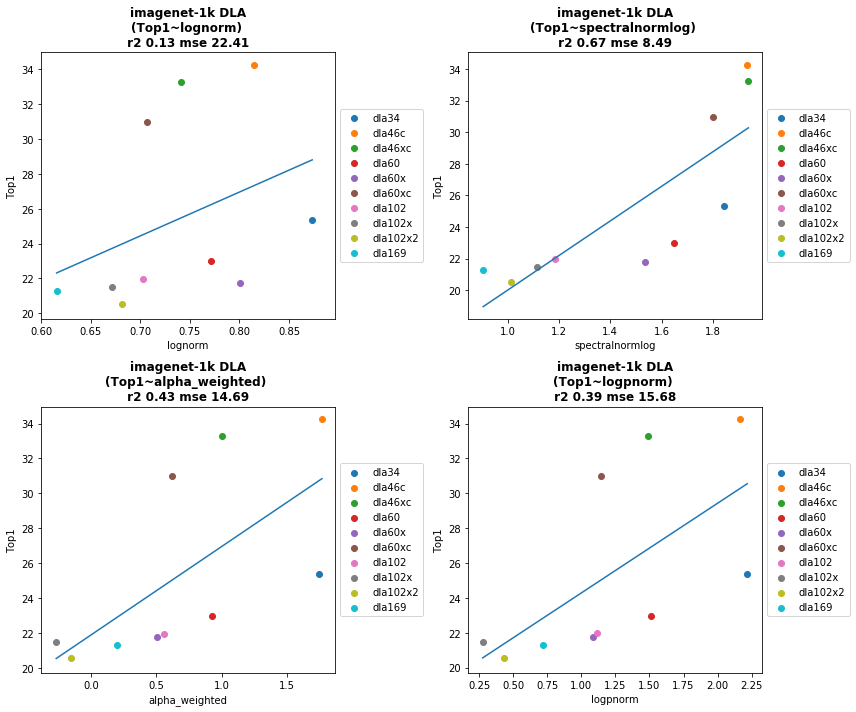

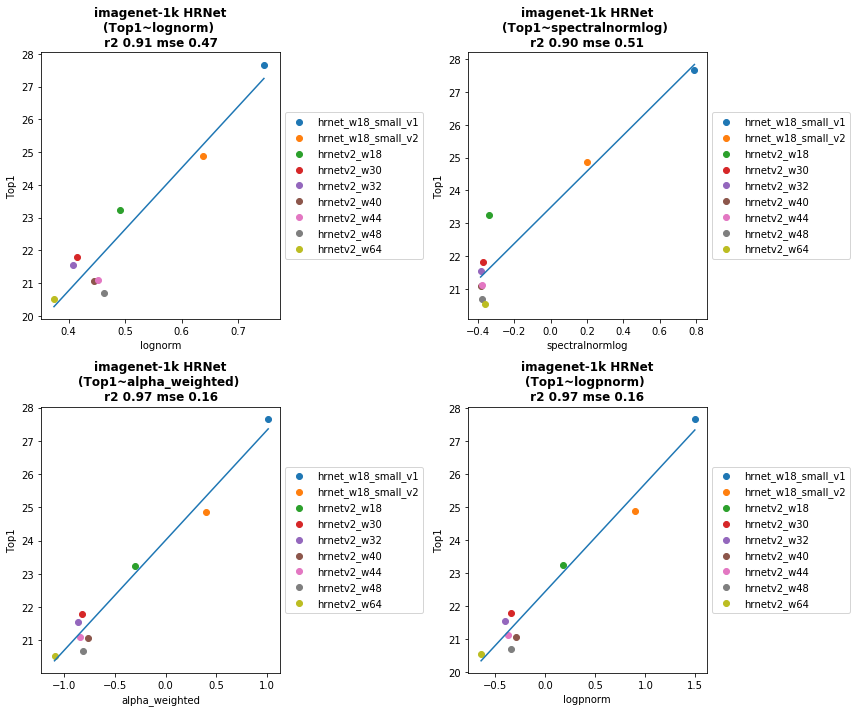

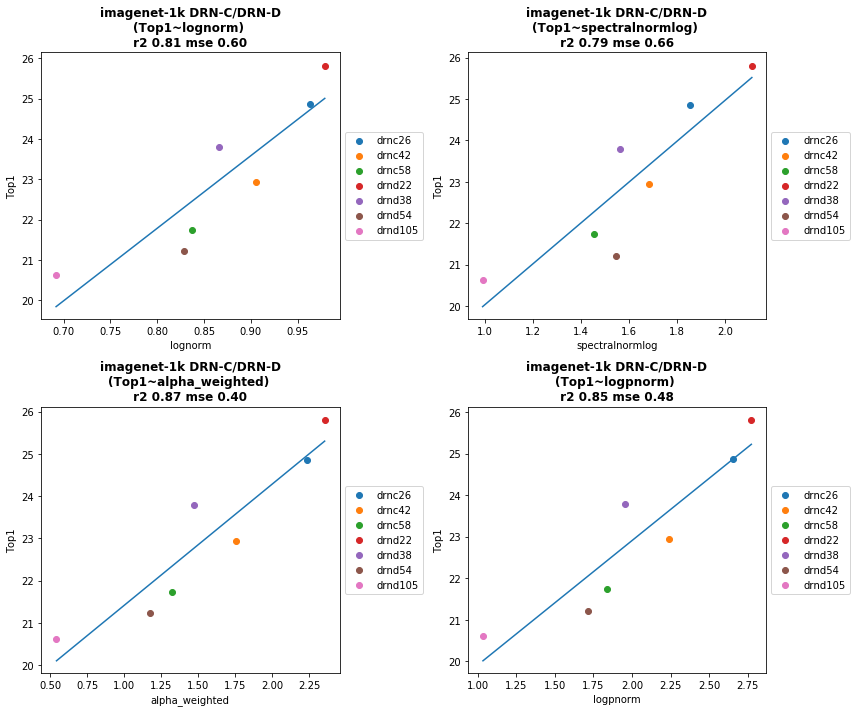

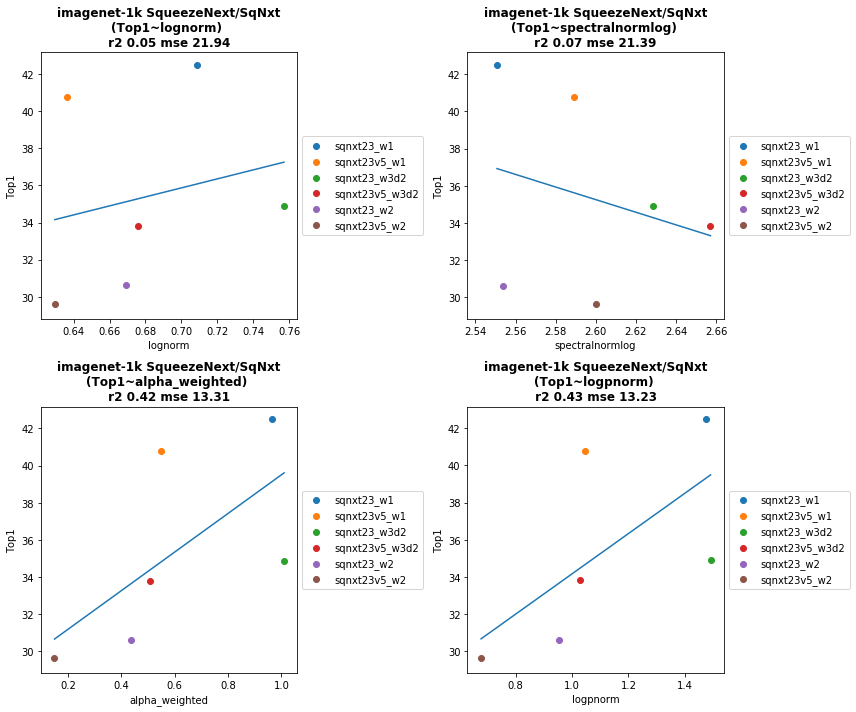

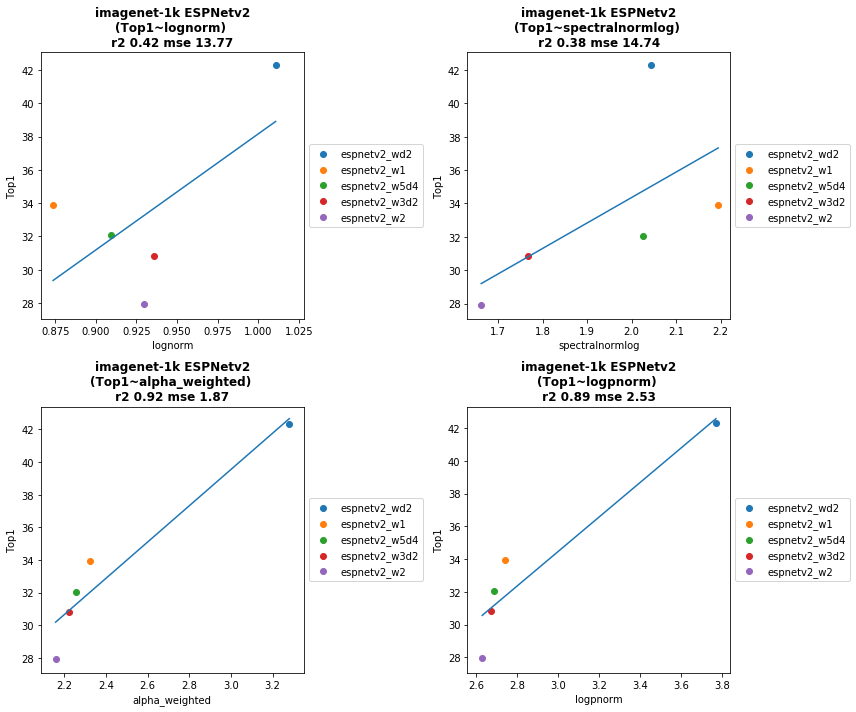

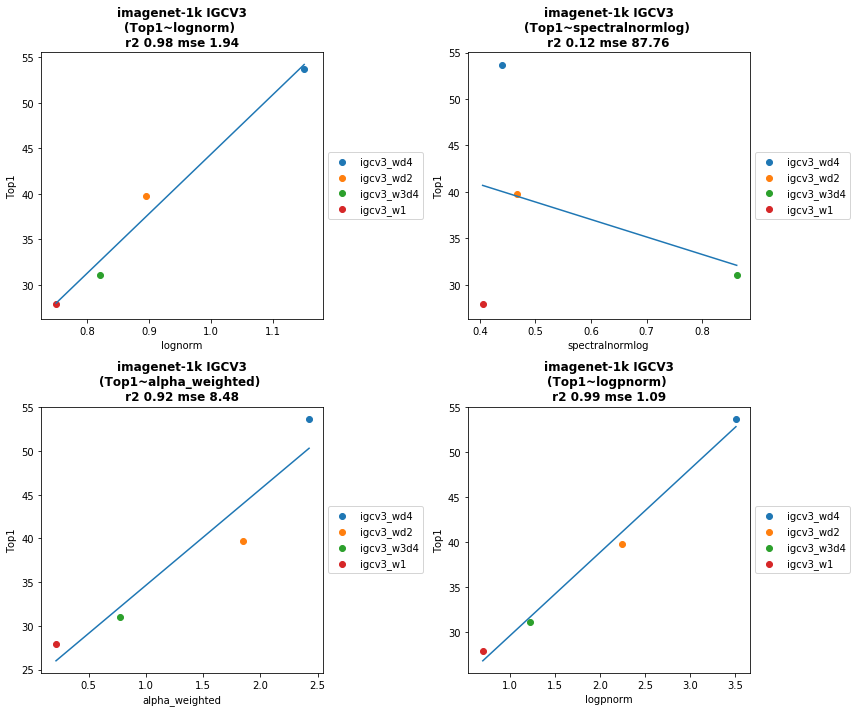

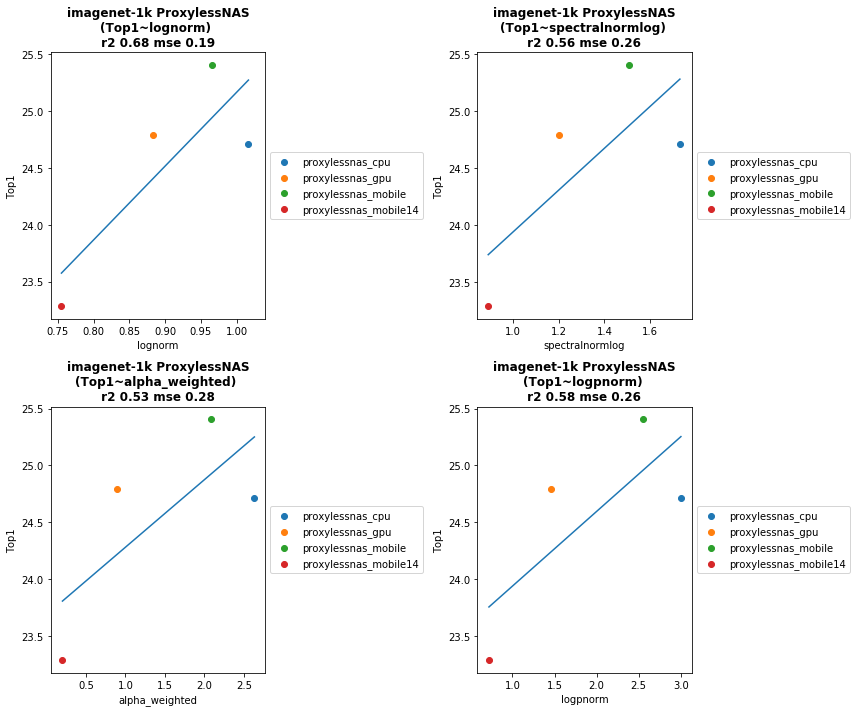

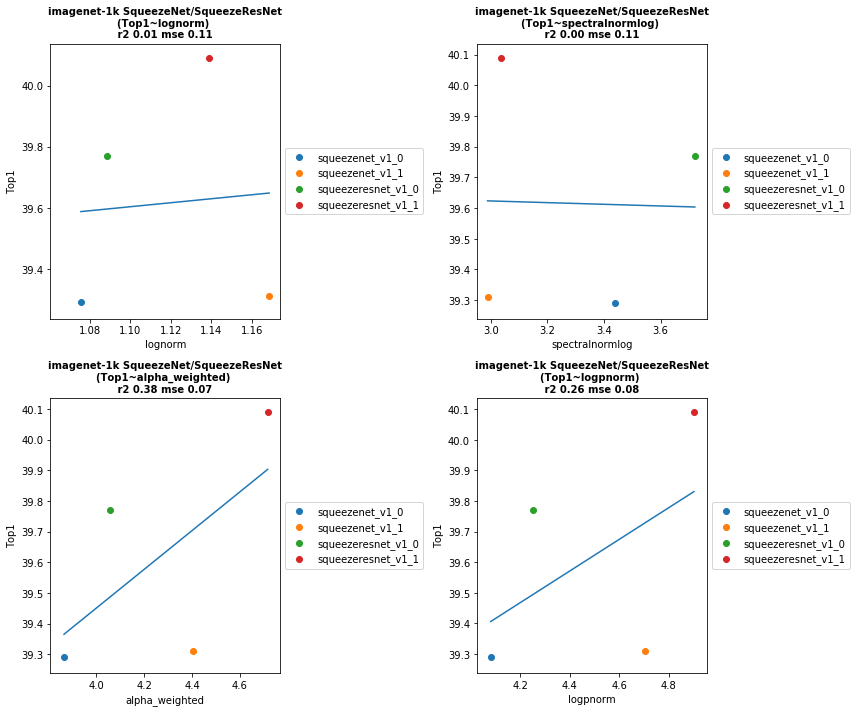

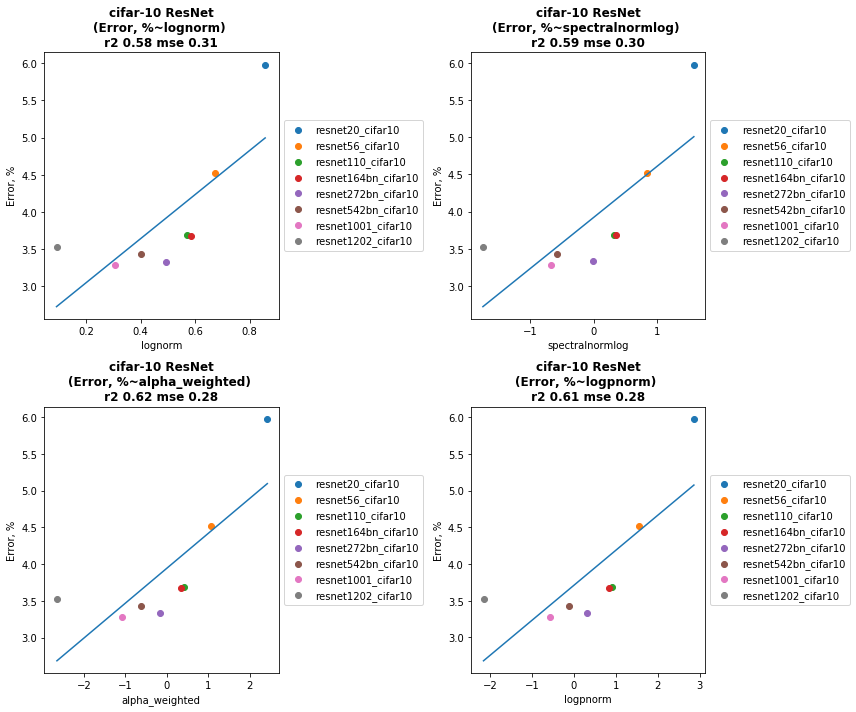

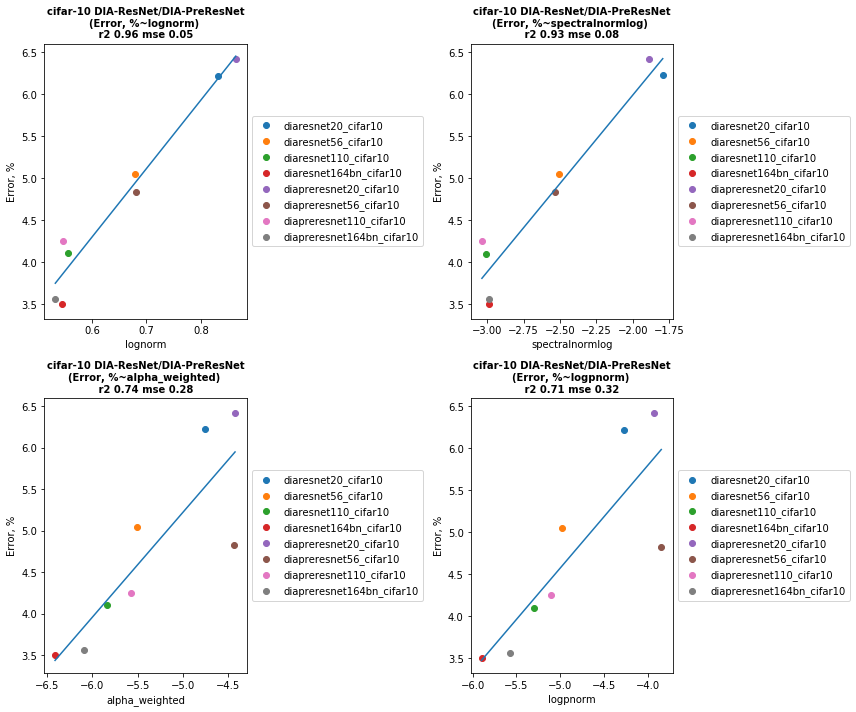

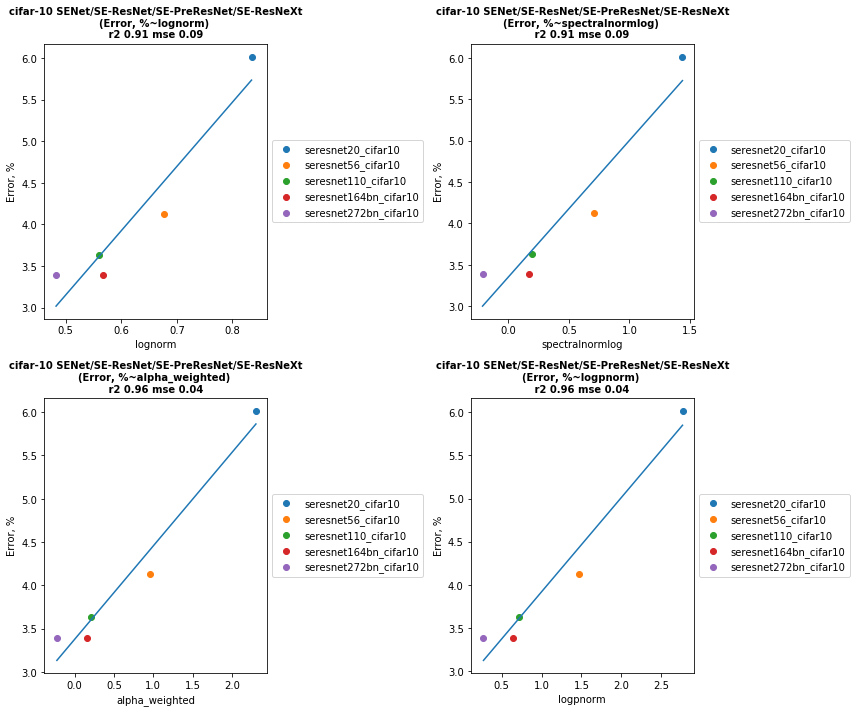

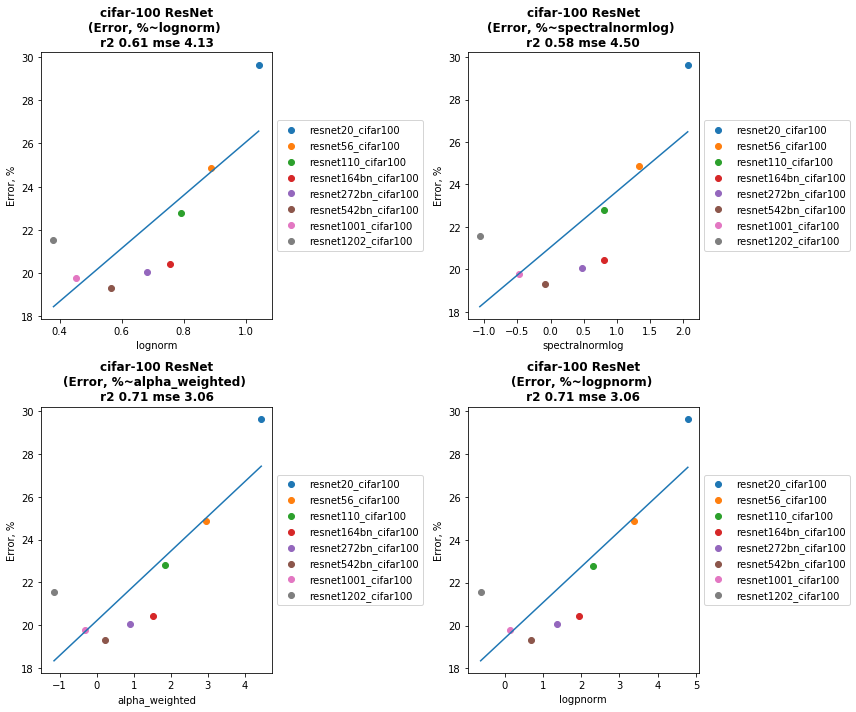

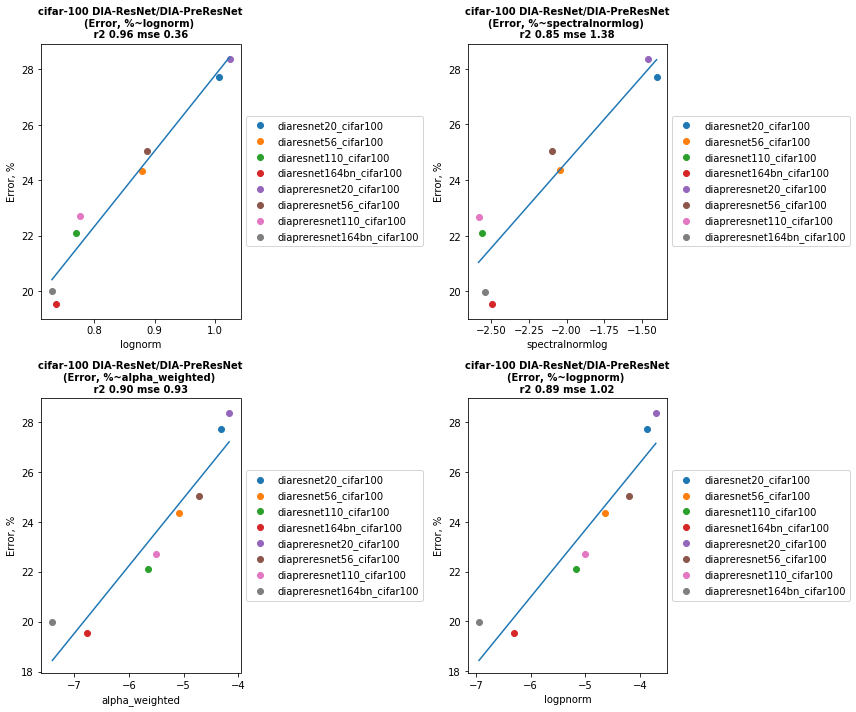

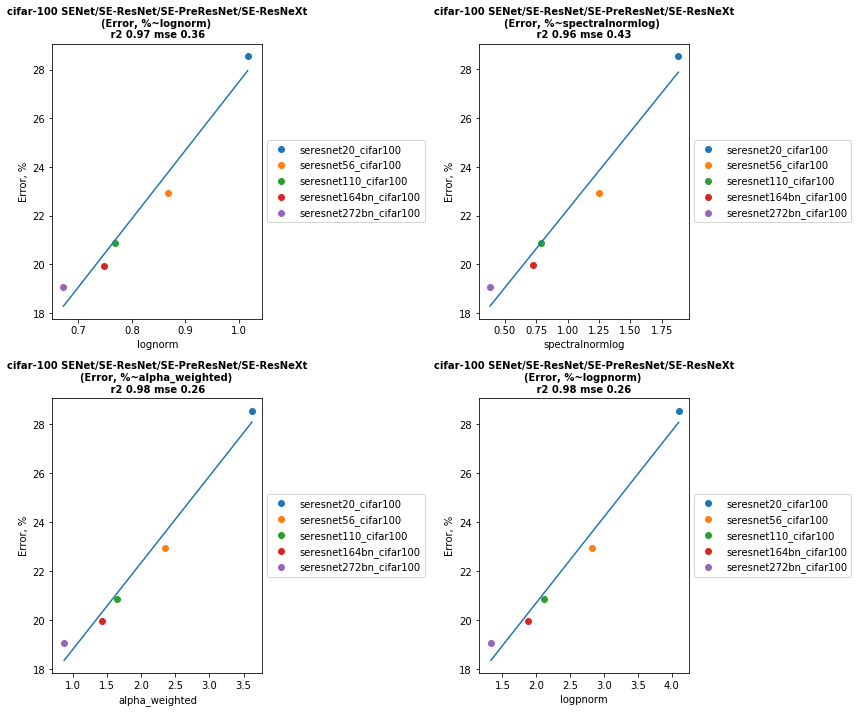

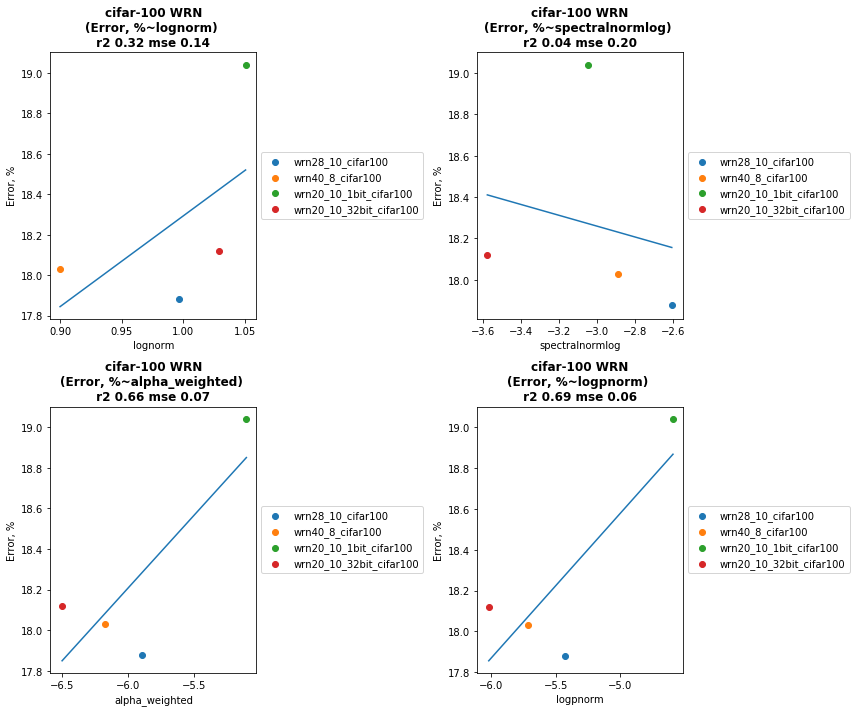

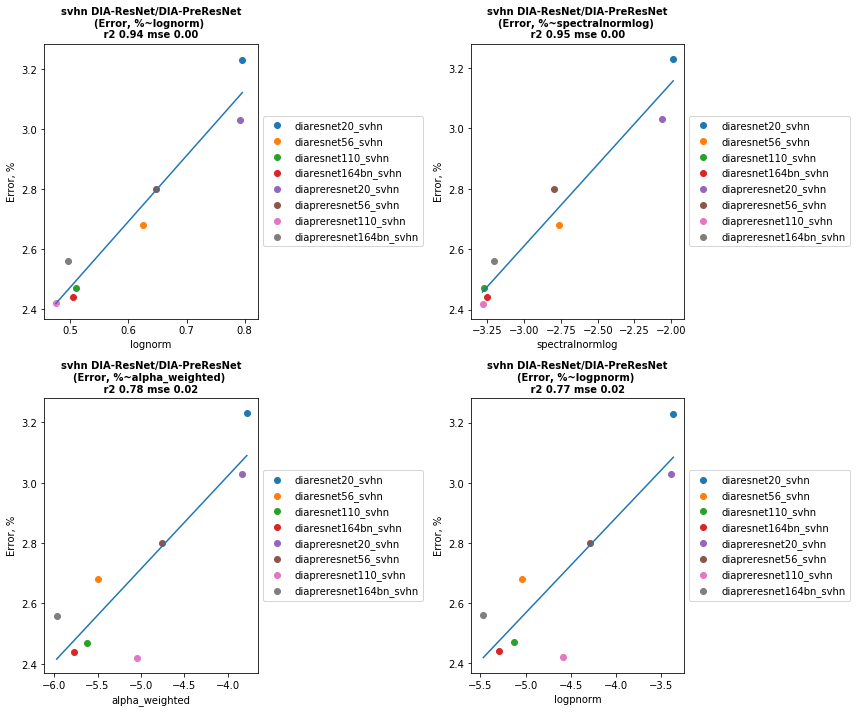

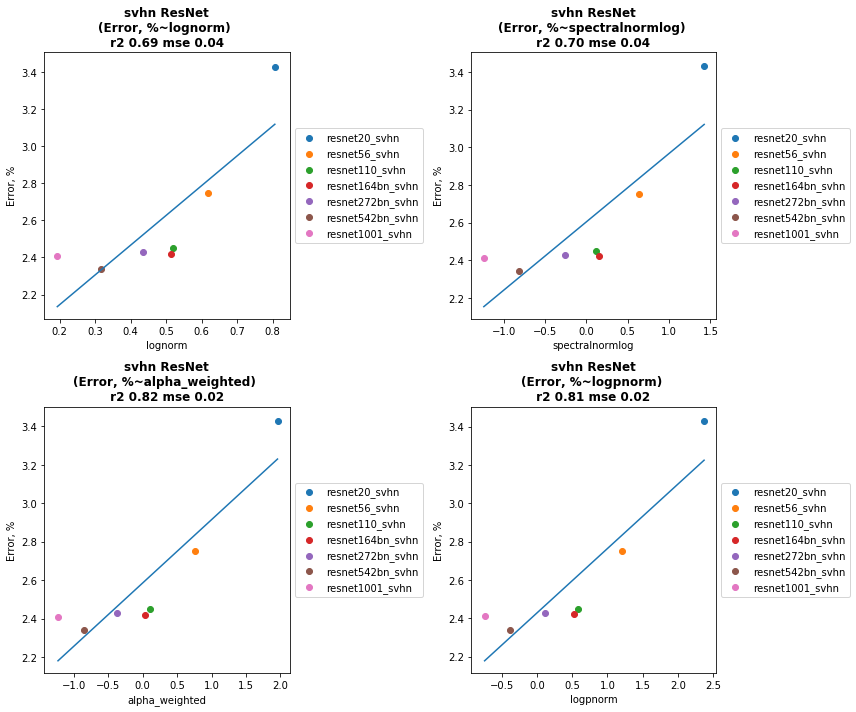

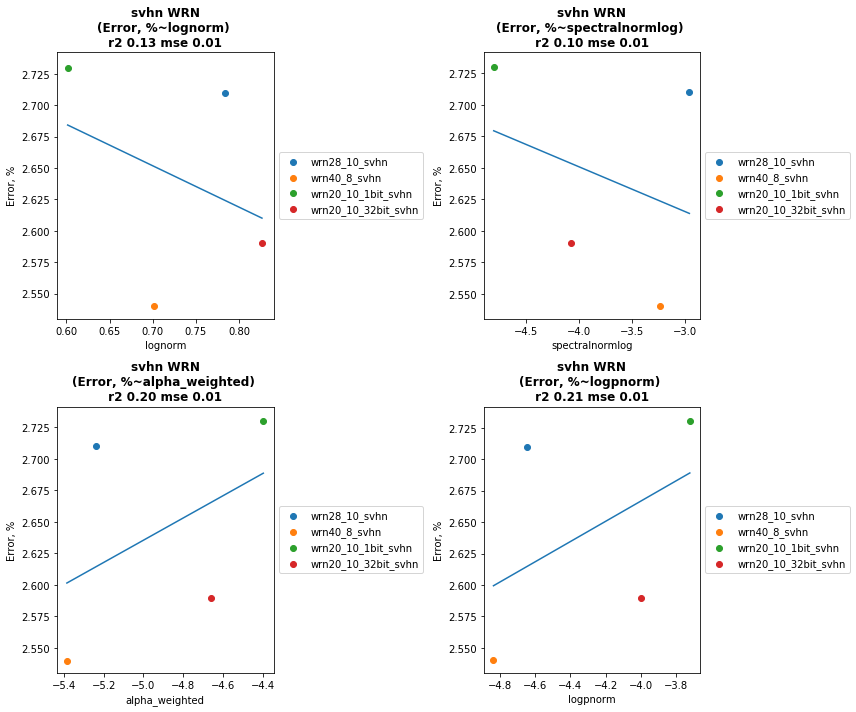

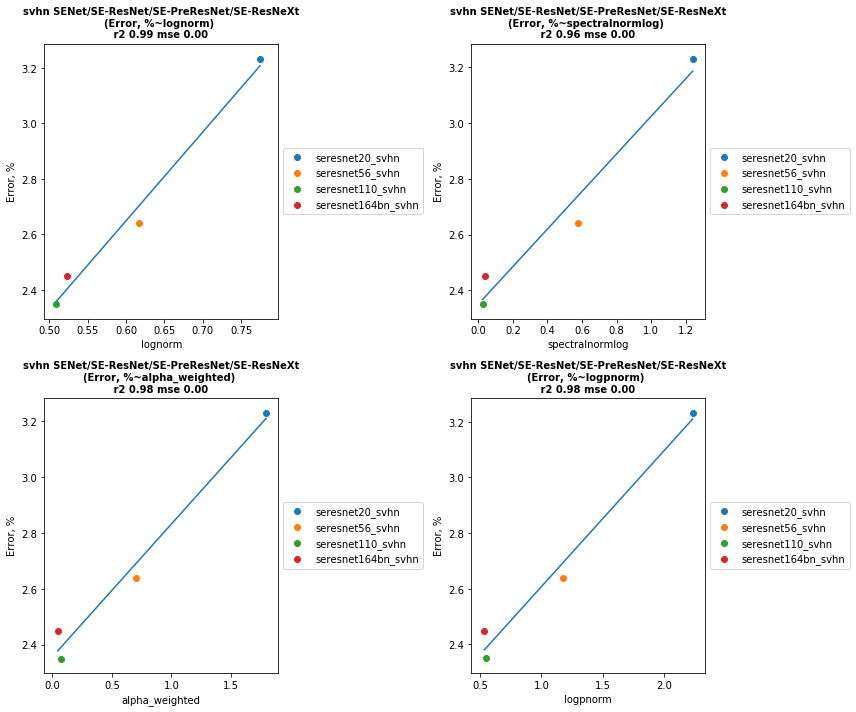

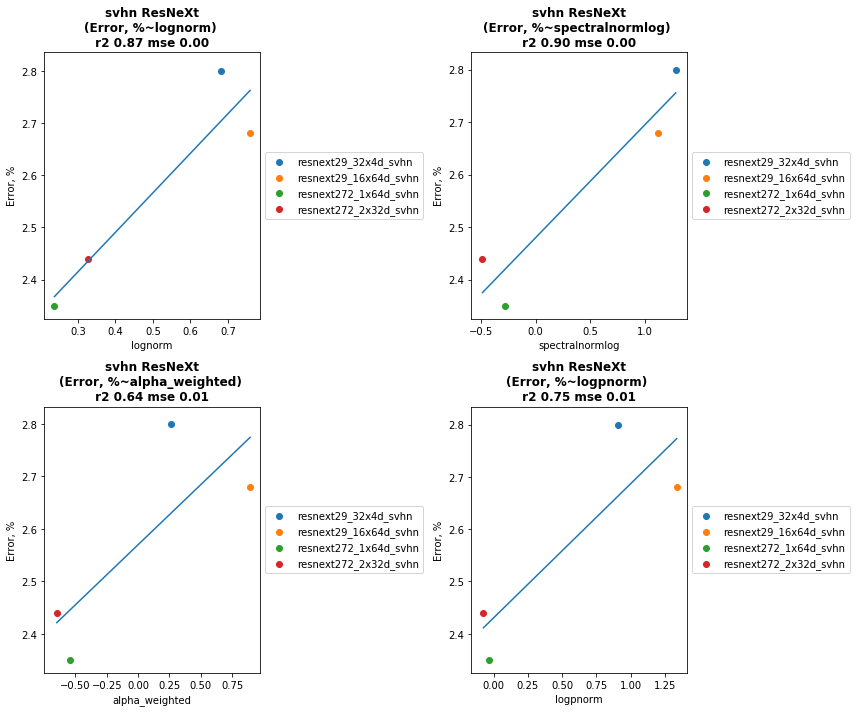

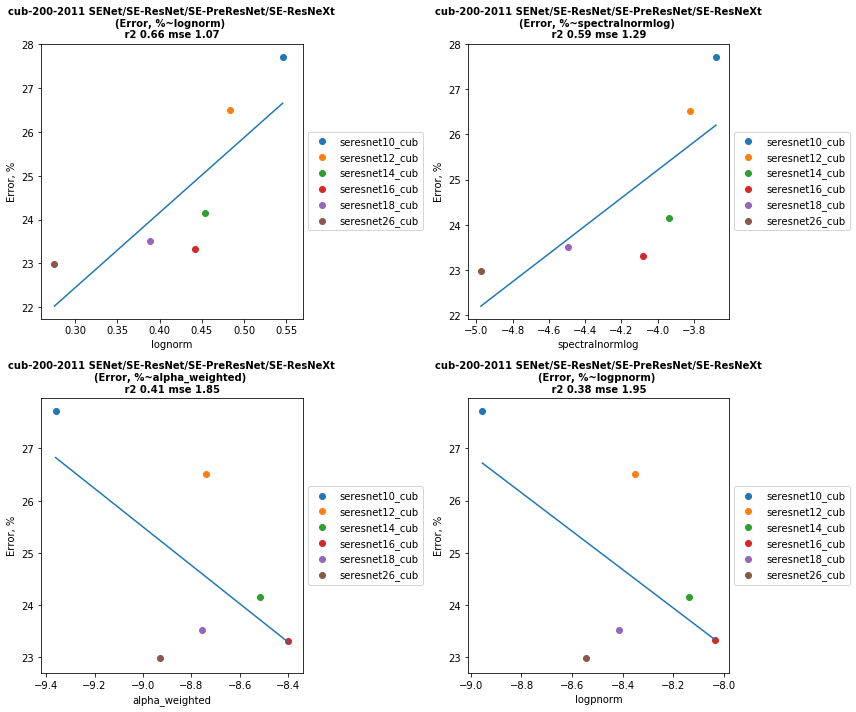

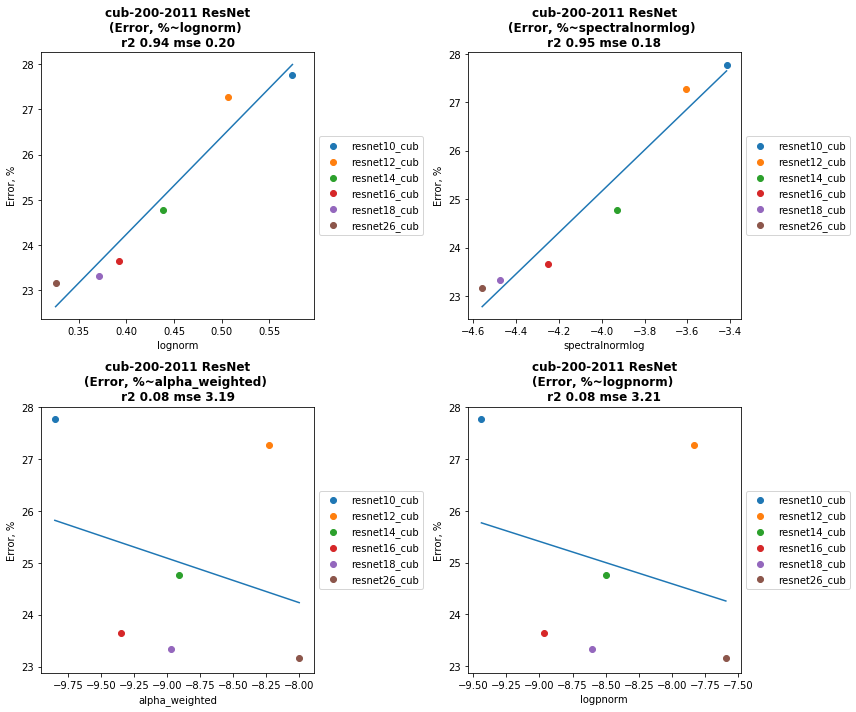

In [31]:
'''Fit a simple or polynomial on to the graph from above
ALL SIMPLE LINEAR FIT

output:
-------------------
1. Plots
2. df_fit (next cell): records the X, Y, degree, SSE and MSE for the fit'''
import warnings

metrics = [  'lognorm' ,'spectralnormlog',  'alpha_weighted' , 'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

num_rows = 2
num_cols = 2

min_num_models = 4

#    ply_degree = 2
df_fit = []
for d in datasets:
    df = df_full[d].copy()
    df.dropna(inplace=True)

    this_groups = df['group'].value_counts().to_frame()

    
    for g in this_groups[this_groups['group'] >= min_num_models].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.dropna().reset_index(drop = True)
        n = len(this_group) #size

        tacc = [c for c in metrics_acc if c in this_group.columns]

        plotloc = int(len(tacc)*len(metrics)/num_rows*100 + 10*num_cols + 1)

        if len(tacc) > 1:
            plt.figure(figsize = (12,20))
        else:
            plt.figure(figsize = (12,10))
        
        #if the size is too small, fit a linear reg; otherwise, fit a polynomial
        if n > 1000: #10: 
            this_deg = 2
        else:
            this_deg = 1
            
        for ac in tacc:#metrics_acc:
            for x in metrics:

                try:
                  plt.subplot(plotloc)
                  for i in range(len(this_group)):
                      plt.scatter(this_group.loc[i,x], this_group.loc[i, ac], label = this_group.loc[i, 'modelname'])
                  plt.xlabel(x)
                  plt.ylabel(ac)
                  title = '{} {}\n({}~{})'.format(d, g,ac, x)
                 
                  # this_fit = np.polyfit(this_group[x], this_group[ac], 
                  #                       this_deg ,full = True)
                  # coef = this_fit[0]

                  try:

                    with warnings.catch_warnings():
                      warnings.simplefilter("ignore")  

                      this_fit = sm.OLS(this_group[ac], sm.add_constant( this_group[x] )).fit()
                      coef = this_fit.params[x] 
                      this_x = np.linspace(min(this_group[x]), max(this_group[x]), 50)

                      plt.plot(this_x, this_fit.predict(sm.add_constant(this_x))) ##coef[0]*this_x**2 + coef[1]*this_x + coef[2]) 
                      this_sse = this_fit.ssr 
                      this_rsquared = this_fit.rsquared

                      this_arch = [d, g, ac, x, this_deg, n, this_rsquared, this_sse, this_sse/n]
                      title += " \n r2 {:03.2f} mse {:03.2f} ".format(this_rsquared, this_sse/n)

                      if len(g) > 20:
                          plt.title(title, fontweight = 'bold', fontsize = 10)
                      else:
                          plt.title(title, fontweight = 'bold')

                      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #this_group['Model']
                      plt.tight_layout()


                  except:
                      pass
                      # try:
                      #     this_sse = np.sum((coef[0]*this_group[x]**2 + coef[1]*this_group[x] + coef[2] - this_group[ac])**2)
                      # except:
                      #     this_sse = np.sum((coef[0]*this_group[x] + coef[1] - this_group[ac])**2)                                

                except np.linalg.LinAlgError: #does not converge
                    print("{} did not converge {}".format(d))
                    this_arch = [d, g, ac, x, this_deg, n, 'Not converge', np.nan, np.nan]

                df_fit.append(this_arch)
                plotloc += 1

            



In [32]:
df_fit = pd.DataFrame(df_fit, columns = ['Dataset', 'Archtecture', 'Test Accuracy', 
                                          'x Variable', 'Poly Degree','# of Models', 
                                         'r^2', 'SSE', 'MSE'])

print("number of records {}".format(len(df_fit)))
df_fit.dropna(inplace=True)

del this_groups
del this_group
del this_x
del this_sse

print("number of records {}".format(len(df_fit)))

number of records 108
number of records 108


In [33]:
df_fit.head()

,Dataset,Archtecture,Test Accuracy,x Variable,Poly Degree,# of Models,r^2,SSE,MSE
0,imagenet-1k,ResNet,Top1,lognorm,1,22,0.821930,131.010499,5.955023
1,imagenet-1k,ResNet,Top1,spectralnormlog,1,22,0.670243,242.609960,11.027725
2,imagenet-1k,ResNet,Top1,alpha_weighted,1,22,0.895091,77.184075,3.508367
3,imagenet-1k,ResNet,Top1,logpnorm,1,22,0.880034,88.261641,4.011893
4,imagenet-1k,EfficientNet,Top1,lognorm,1,20,0.651727,53.484190,2.674210


In [0]:
## df_fit records the X, Y, SSE, and MSE for the fit
df_fit.to_excel(path + '/' + 'df_fit.xlsx')


In [35]:
for x in ['r^2', 'MSE']:
    temp = df_fit.copy()
    print(len(temp))
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp.describe()
    display(summary)
    print('===============================================')

del df_fitp

108
108
For r^2:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,0.684549,0.668787,0.686560,0.600493
std,0.253631,0.304884,0.258063,0.335308
min,0.083627,0.005399,0.076199,0.000602
25%,0.483012,0.593980,0.513341,0.367372
50%,0.738633,0.710748,0.745447,0.671343
75%,0.897850,0.925918,0.885410,0.901194
max,0.979183,0.985519,0.989105,0.962670


108
108
For MSE:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,2.976577,4.430053,2.743525,9.643391
std,5.078184,8.780475,4.924675,23.492264
min,0.002421,0.001684,0.002322,0.003125
25%,0.069389,0.099987,0.073486,0.100774
50%,0.404478,0.363396,0.477335,0.511909
75%,3.125359,3.400413,2.798186,6.493633
max,19.537656,35.379455,18.480655,89.579949


In [36]:
for x in ['r^2', 'MSE']:
    temp = df_fit.copy()
    print(len(temp))
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp.describe()
    display(summary)
    print('===============================================')

del df_fitp

108
108
For r^2:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,0.684549,0.668787,0.686560,0.600493
std,0.253631,0.304884,0.258063,0.335308
min,0.083627,0.005399,0.076199,0.000602
25%,0.483012,0.593980,0.513341,0.367372
50%,0.738633,0.710748,0.745447,0.671343
75%,0.897850,0.925918,0.885410,0.901194
max,0.979183,0.985519,0.989105,0.962670


108
108
For MSE:


x Variable,alpha_weighted,lognorm,logpnorm,spectralnormlog
count,27.000000,27.000000,27.000000,27.000000
mean,2.976577,4.430053,2.743525,9.643391
std,5.078184,8.780475,4.924675,23.492264
min,0.002421,0.001684,0.002322,0.003125
25%,0.069389,0.099987,0.073486,0.100774
50%,0.404478,0.363396,0.477335,0.511909
75%,3.125359,3.400413,2.798186,6.493633
max,19.537656,35.379455,18.480655,89.579949


### **Tables in paper**

In [37]:
pd.options.display.float_format = '{:,.3f} '.format
for x in ['r^2', 'MSE']:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
    display(summary.loc[['mean', 'std']])
    print('===============================================')

del df_fitp

108
For r^2:


x Variable,lognorm,spectralnormlog,alpha_weighted,logpnorm
mean,0.669,0.600,0.685,0.687
std,0.305,0.335,0.254,0.258


108
For MSE:


x Variable,lognorm,spectralnormlog,alpha_weighted,logpnorm
mean,4.430,9.643,2.977,2.744
std,8.780,23.492,5.078,4.925


Datasets



In [38]:
temp = df_fit.copy()
temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
display(temp.Dataset.value_counts())

imagenet-1k     52
svhn            20
cifar-100       16
cifar-10        12
cub-200-2011     8
Name: Dataset, dtype: int64

In [39]:
display(temp.Archtecture.value_counts())

ResNet                                     20
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt    16
DIA-ResNet/DIA-PreResNet                   12
WRN                                         8
SqueezeNext/SqNxt                           4
DRN-C/DRN-D                                 4
EfficientNet                                4
ResNeXt                                     4
ESPNetv2                                    4
ProxylessNAS                                4
ShuffleNet                                  4
PreResNet                                   4
VGG/BN-VGG                                  4
DLA                                         4
IGCV3                                       4
HRNet                                       4
SqueezeNet/SqueezeResNet                    4
Name: Archtecture, dtype: int64

In [40]:
len(temp.Archtecture.value_counts())

17

In [41]:
np.sum(temp.Archtecture.value_counts())

108

## More Plots for Appendix

Plots

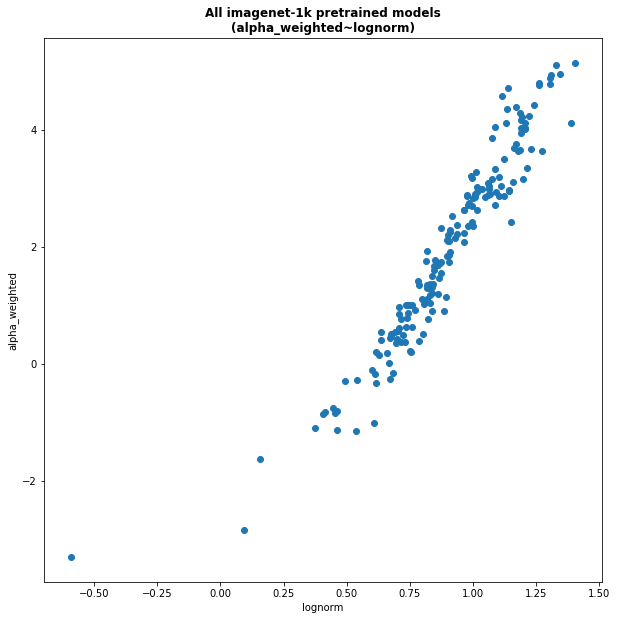

<Figure size 720x720 with 0 Axes>

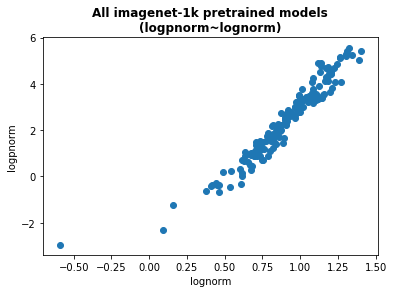

<Figure size 720x720 with 0 Axes>

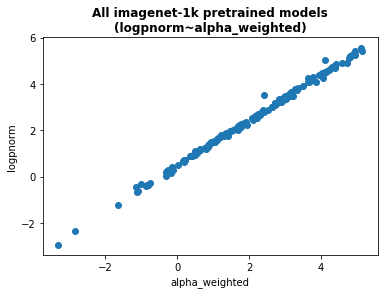

<Figure size 720x720 with 0 Axes>

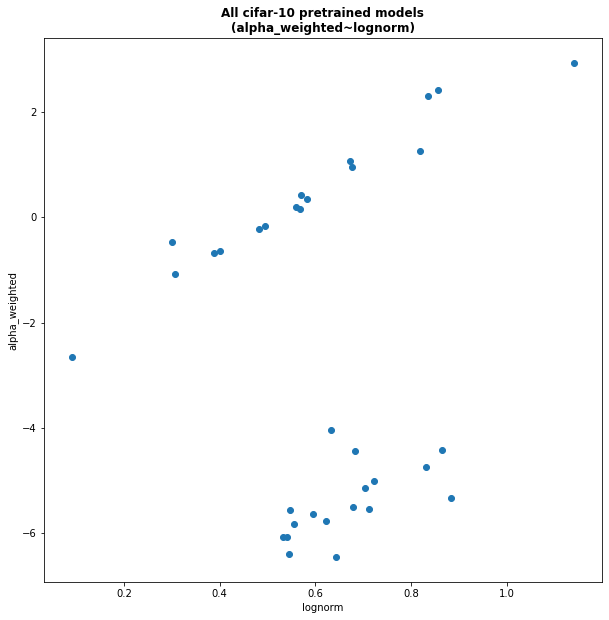

<Figure size 720x720 with 0 Axes>

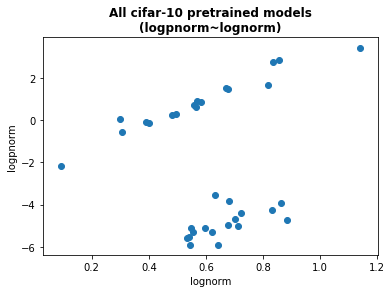

<Figure size 720x720 with 0 Axes>

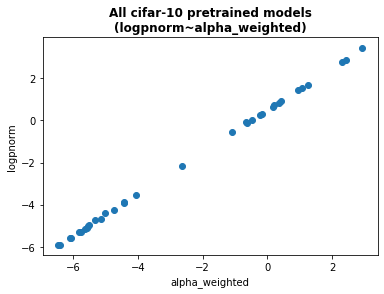

<Figure size 720x720 with 0 Axes>

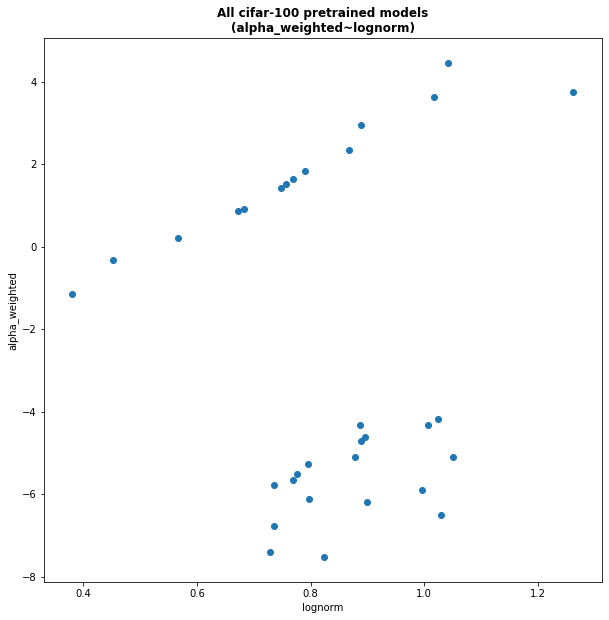

<Figure size 720x720 with 0 Axes>

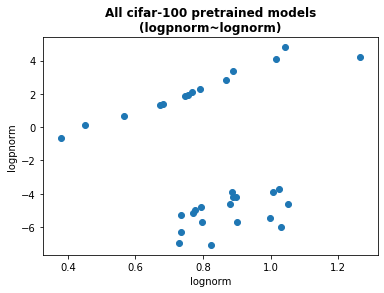

<Figure size 720x720 with 0 Axes>

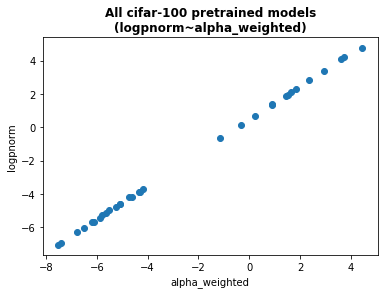

<Figure size 720x720 with 0 Axes>

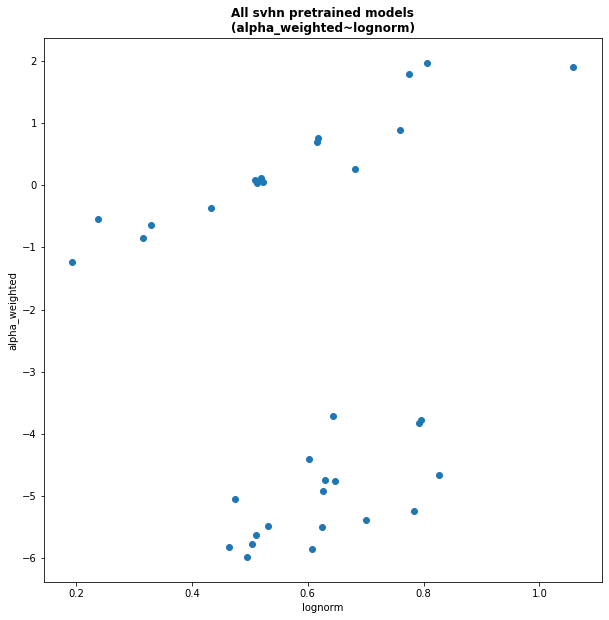

<Figure size 720x720 with 0 Axes>

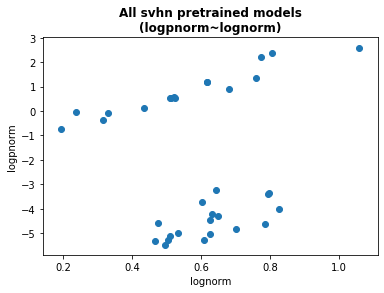

<Figure size 720x720 with 0 Axes>

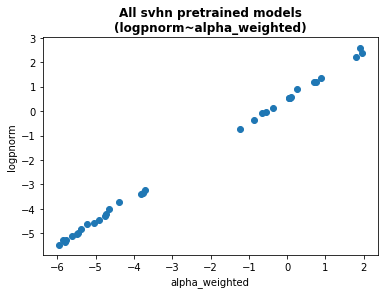

<Figure size 720x720 with 0 Axes>

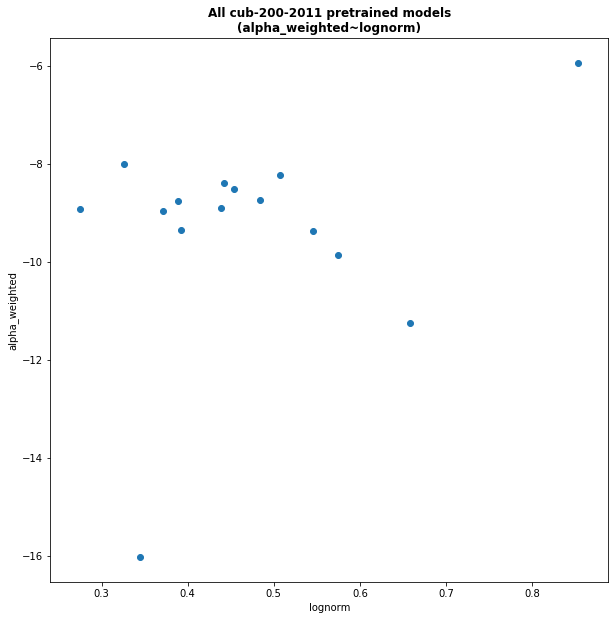

<Figure size 720x720 with 0 Axes>

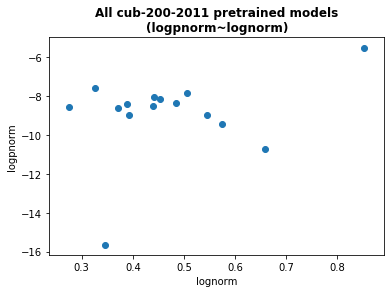

<Figure size 720x720 with 0 Axes>

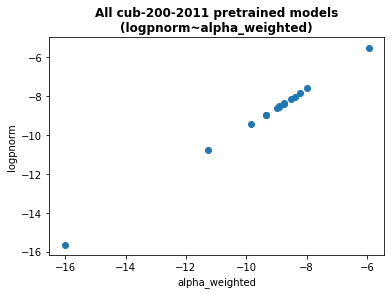

<Figure size 720x720 with 0 Axes>

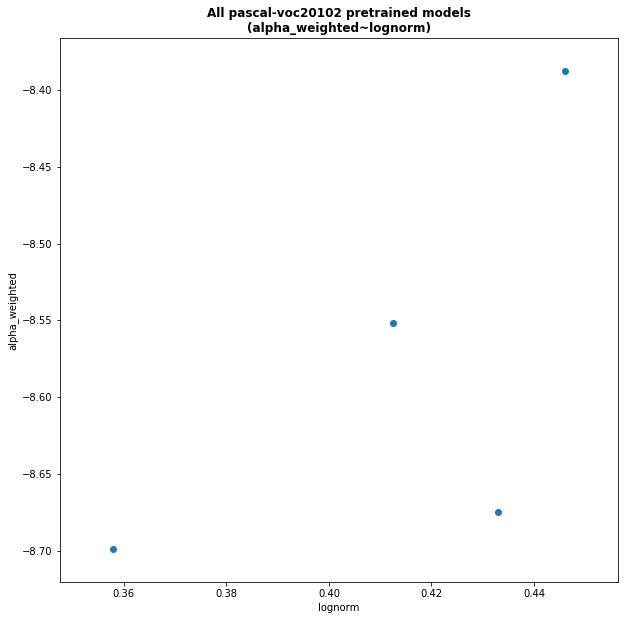

<Figure size 720x720 with 0 Axes>

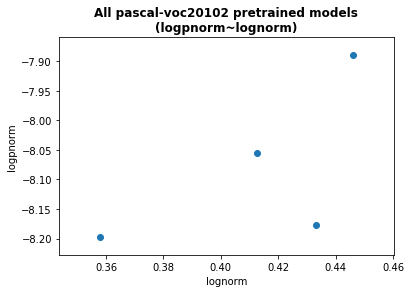

<Figure size 720x720 with 0 Axes>

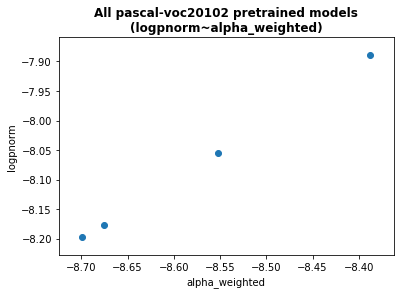

<Figure size 720x720 with 0 Axes>

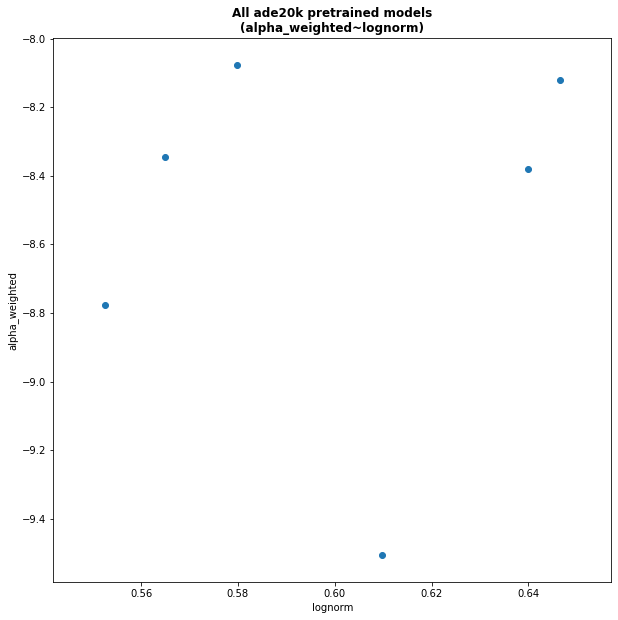

<Figure size 720x720 with 0 Axes>

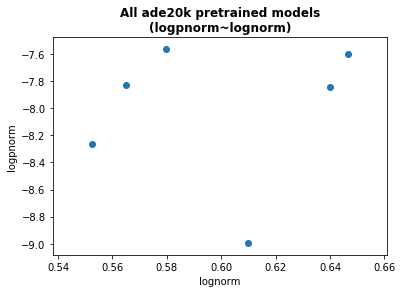

<Figure size 720x720 with 0 Axes>

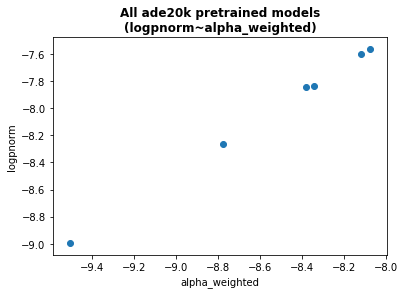

<Figure size 720x720 with 0 Axes>

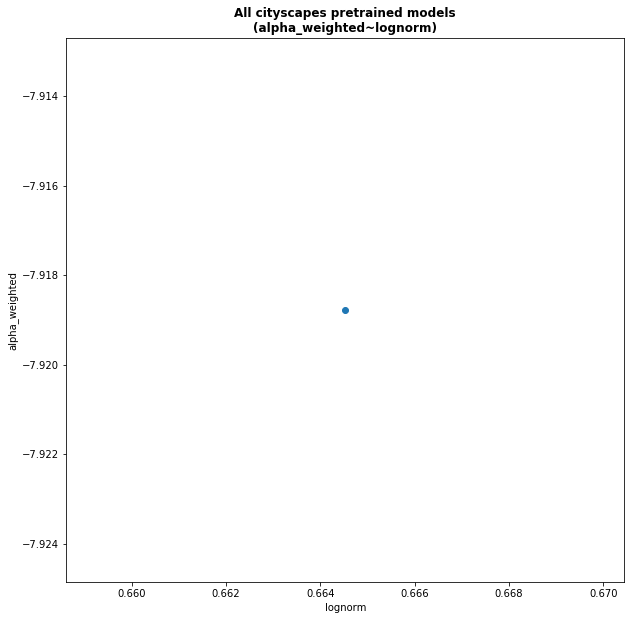

<Figure size 720x720 with 0 Axes>

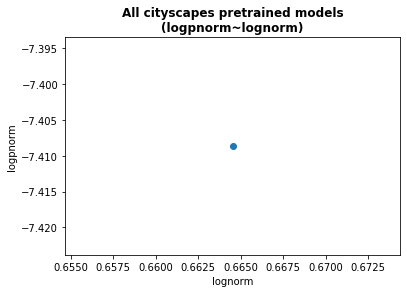

<Figure size 720x720 with 0 Axes>

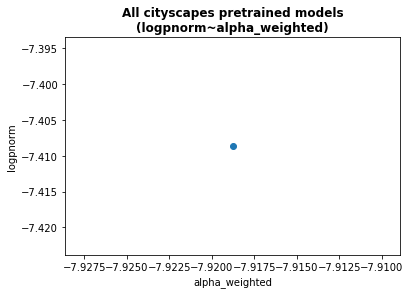

<Figure size 720x720 with 0 Axes>

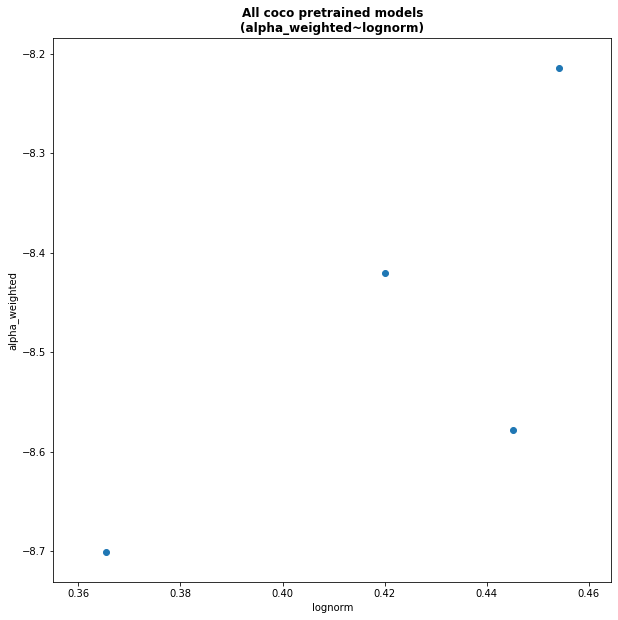

<Figure size 720x720 with 0 Axes>

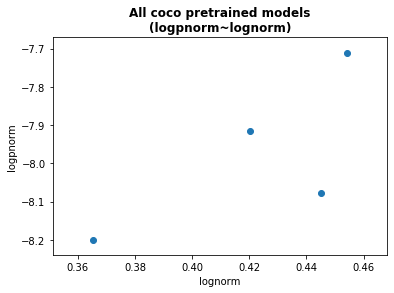

<Figure size 720x720 with 0 Axes>

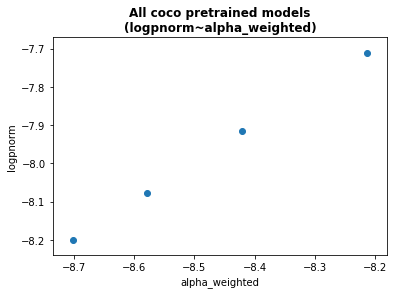

<Figure size 720x720 with 0 Axes>

In [42]:
'''Between the ww metrics
no alpha_weighted'''

for d in datasets:
    temp = df_full[d].copy()
    df = temp.dropna()
    if len(temp) == 1:
        continue

    plotloc = 131
    plt.figure(figsize = (10,10))
    for x, y in itertools.combinations(metrics[:1] + metrics[2:],2):
        #plt.subplot(plotloc)
        plt.scatter(df[x], df[y])
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('All {} pretrained models\n({}~{})'.format(d, y, x), 
                  fontweight = 'bold')
        plt.figure(figsize = (10,10))
        plt.tight_layout()
        plt.show()

        plotloc += 1

    

del temp


## Appendix

In [43]:
temp = df_fit.copy()
df_appndx = temp[temp['# of Models'] > 3].reset_index(drop = True)

df_appndx.head()

,Dataset,Archtecture,Test Accuracy,x Variable,Poly Degree,# of Models,r^2,SSE,MSE
0,imagenet-1k,ResNet,Top1,lognorm,1,22,0.822,131.010,5.955
1,imagenet-1k,ResNet,Top1,spectralnormlog,1,22,0.670,242.610,11.028
2,imagenet-1k,ResNet,Top1,alpha_weighted,1,22,0.895,77.184,3.508
3,imagenet-1k,ResNet,Top1,logpnorm,1,22,0.880,88.262,4.012
4,imagenet-1k,EfficientNet,Top1,lognorm,1,20,0.652,53.484,2.674


In [44]:
len(df_appndx)

108

In [0]:
series_names = df_appndx.Archtecture.unique()
dataset_names = df_appndx.Dataset.unique()

In [46]:
dataset_names

array(['imagenet-1k', 'cifar-10', 'cifar-100', 'svhn', 'cub-200-2011'],
      dtype=object)

In [66]:
import re

    
print("Dataset & Model & Fnorm & Snorm & wAlpha & aNorm \\\\")
for dname in dataset_names: 
  print("\hline")
  for sname in series_names:
    sname_fixed = re.sub(r"/.*","",sname)

    df_ = df_appndx[df_appndx.Archtecture==sname]
    df_ = df_[df_.Dataset==dname]
    if (len(df_) > 0):
      r2 = df_[df_['x Variable']=='logpnorm']['r^2'].to_numpy()[0]
#      if r2 > 0.0:
      fnorm_mse = df_[df_['x Variable']=='lognorm'].MSE.to_numpy()[0]
      snorm_mse = df_[df_['x Variable']=='spectralnormlog'].MSE.to_numpy()[0]
      wa_mse = df_[df_['x Variable']=='alpha_weighted'].MSE.to_numpy()[0]
      anorm_mse = df_[df_['x Variable']=='logpnorm'].MSE.to_numpy()[0]

      all_mse = np.array([fnorm_mse, snorm_mse, wa_mse, anorm_mse])
      min_mse_idx = np.argmin(all_mse)
      if min_mse_idx==0:
               print(" {} & {}  & \\textbf[{:03.2f}] &  {:03.2f} & {:03.2f} & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      elif  min_mse_idx==1:
               print(" {} & {}  & {:03.2f} &  \\textbf[{:03.2f}] & {:03.2f} & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      elif  min_mse_idx==2:
               print(" {} & {}  & {:03.2f} &  {:03.2f} & \\textbf[{:03.2f}] & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      else:
       print(" {} & {}  & {:03.2f} &  {:03.2f} & {:03.2f} & \\textbf[{:03.2f}] \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))
  

Dataset & Model & Fnorm & Snorm & wAlpha & aNorm \\
\hline
 imagenet-1k & ResNet  & 5.96 &  11.03 & \textbf[3.51] & 4.01 \\
 imagenet-1k & EfficientNet  & 2.67 &  \textbf[1.23] & 2.56 & 2.50 \\
 imagenet-1k & PreResNet  & 6.59 &  15.44 & \textbf[3.59] & 3.71 \\
 imagenet-1k & ShuffleNet  & 35.38 &  89.58 & 19.54 & \textbf[18.48] \\
 imagenet-1k & VGG  & 0.84 &  \textbf[0.68] & 1.89 & 1.59 \\
 imagenet-1k & DLA  & 22.41 &  \textbf[8.49] & 14.69 & 15.68 \\
 imagenet-1k & HRNet  & 0.47 &  0.51 & \textbf[0.16] & 0.16 \\
 imagenet-1k & DRN-C  & 0.60 &  0.66 & \textbf[0.40] & 0.48 \\
 imagenet-1k & SqueezeNext  & 21.94 &  21.39 & 13.31 & \textbf[13.23] \\
 imagenet-1k & ESPNetv2  & 13.77 &  14.74 & \textbf[1.87] & 2.53 \\
 imagenet-1k & IGCV3  & 1.94 &  87.76 & 8.48 & \textbf[1.09] \\
 imagenet-1k & ProxylessNAS  & \textbf[0.19] &  0.26 & 0.28 & 0.26 \\
 imagenet-1k & SqueezeNet  & 0.11 &  0.11 & \textbf[0.07] & 0.08 \\
\hline
 cifar-10 & ResNet  & 0.31 &  0.30 & \textbf[0.28] & 0.28 \\
 cif

(array([1.06945724, 1.28639781, 1.85251973, 0.94779066]), 3)

In [67]:

print("Dataset & Model & Fnorm & Snorm & wAlpha & aNorm \\\\")
for dname in dataset_names: 
  print("\hline")
  for sname in series_names:
    sname_fixed = re.sub(r"/.*","",sname)

    df_ = df_appndx[df_appndx.Archtecture==sname]
    df_ = df_[df_.Dataset==dname]
    if (len(df_) > 0):
      fnorm_r2 = df_[df_['x Variable']=='lognorm']['r^2'].to_numpy()[0]
      snorm_r2 = df_[df_['x Variable']=='spectralnormlog']['r^2'].to_numpy()[0]
      wa_r2 = df_[df_['x Variable']=='alpha_weighted']['r^2'].to_numpy()[0]
      anorm_r2 = df_[df_['x Variable']=='logpnorm']['r^2'].to_numpy()[0]

      all_mse = np.array([fnorm_r2, snorm_r2, wa_r2, anorm_r2])
      min_mse_idx = np.argmax(all_mse)
      if min_mse_idx==0:
               print(" {} & {}  & \\textbf[{:03.2f}] &  {:03.2f} & {:03.2f} & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      elif  min_mse_idx==1:
               print(" {} & {}  & {:03.2f} &  \\textbf[{:03.2f}] & {:03.2f} & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      elif  min_mse_idx==2:
               print(" {} & {}  & {:03.2f} &  {:03.2f} & \\textbf[{:03.2f}] & {:03.2f} \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))

      else:
       print(" {} & {}  & {:03.2f} &  {:03.2f} & {:03.2f} & \\textbf[{:03.2f}] \\\\".format(dname, sname_fixed, fnorm_mse, snorm_mse, wa_mse, anorm_mse))
  
    

Dataset & Model & Fnorm & Snorm & wAlpha & aNorm \\
\hline
 imagenet-1k & ResNet  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 imagenet-1k & EfficientNet  & 1.07 &  \textbf[1.29] & 1.85 & 1.95 \\
 imagenet-1k & PreResNet  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 imagenet-1k & ShuffleNet  & 1.07 &  1.29 & 1.85 & \textbf[1.95] \\
 imagenet-1k & VGG  & 1.07 &  \textbf[1.29] & 1.85 & 1.95 \\
 imagenet-1k & DLA  & 1.07 &  \textbf[1.29] & 1.85 & 1.95 \\
 imagenet-1k & HRNet  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 imagenet-1k & DRN-C  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 imagenet-1k & SqueezeNext  & 1.07 &  1.29 & 1.85 & \textbf[1.95] \\
 imagenet-1k & ESPNetv2  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 imagenet-1k & IGCV3  & 1.07 &  1.29 & 1.85 & \textbf[1.95] \\
 imagenet-1k & ProxylessNAS  & \textbf[1.07] &  1.29 & 1.85 & 1.95 \\
 imagenet-1k & SqueezeNet  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
\hline
 cifar-10 & ResNet  & 1.07 &  1.29 & \textbf[1.85] & 1.95 \\
 cifar-10 & DIA-ResN